How did you start Notebook
--------------------------

When starting this notebook using this:
```bash
~/tutorial-env/bin/ipython notebook --pylab=inline
```
comment out the code in the following cell.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Generate the data necessary to this project first.**

Generated input data is saved in: /tmp/tmpogrPGD


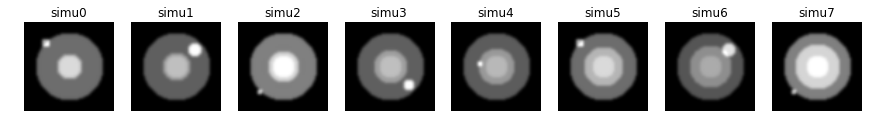

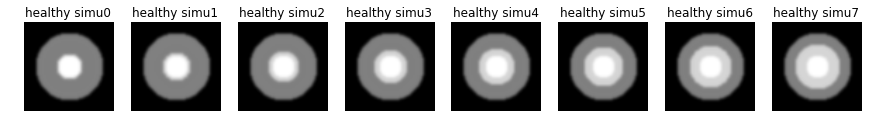

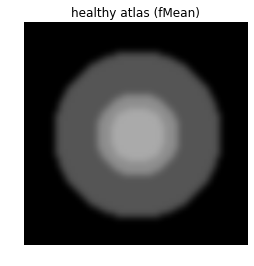

In [2]:
import tempfile
figure()
data_folder=tempfile.mkdtemp()
print "Generated input data is saved in: "+data_folder
%run ../../helper/gen_2D_simulation_data.py $data_folder

In [4]:
import glob
import sys
import os.path
sys.path.append('../')
sys.path.append('../../')
from pyLAR import *
import SimpleITK as sitk

In [14]:
# global parameters
EXE_ConvertToJpg = '/Users/xiaoxiaoliu/work/bin/ANTS/bin/ConvertToJpg'
input_folder = data_folder
result_folder = data_folder +'/LRA_Results'
UAB_result_folder = data_folder +'/UAB_Results'
GT_UAB_result_folder = data_folder +'/GT_UAB_Results'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
if not os.path.exists(UAB_result_folder):
    os.makedirs( UAB_result_folder)
if not os.path.exists(GT_UAB_result_folder):
    os.makedirs( GT_UAB_result_folder)

im_names = glob.glob(input_folder+'/simu*.*')

num_of_data = len(im_names)
x_dim = 64
y_dim = 64

# data selection
selection = range(num_of_data)
num_of_data = len(selection)

NUM_OF_ITERATIONS = 5

In [6]:
def getImageArray(fn, CONVERT= False):
    if CONVERT:
        img = Image.open(fn).convert('LA')
        newImFn = os.path.splitext(fn)[0]+'.png'
        img.save(newImFn)
        convertToJpg(newImFn)
        os.system('rm '+newImFn)
        newImFn = os.path.splitext(fn)[0]+'.jpg'
        fn = newImFn
    
    im = sitk.ReadImage(fn)
    im_array = sitk.GetArrayFromImage(im)
    return im_array

def convertToJpg(fn):
    outputFn = os.path.splitext(fn)[0]+'.jpg'
    cmd = EXE_ConvertToJpg + ' ' + fn + ' ' + outputFn
    os.system(cmd)
    return outputFn

def showSlice(D, titleN,color,row, referenceIm=None):
    for i in range(num_of_data):
       im = np.array(D[:,i].reshape(x_dim,y_dim))
        
       plt.subplot2grid((3,num_of_data),(row,i))
       implot = plt.imshow(im,color,vmin = 0, vmax = 80)
       plt.axis('off')
       plt.title(titleN+' '+str(i))

In [7]:
antsParams =  {
'Dimension': 2,\
'Convergence' : '[200x100,1e-6,10]',\
'ShrinkFactors' : '2x1',\
'SmoothingSigmas' : '1x0vox',\
'Transform' :'SyN[0.1,1,0]',\
#'Metric': 'Mattes[%s,%s,1,50]' %(fixedIm, movingIm)
'Metric': 'MeanSquares[fixedIm,movingIm, 1,0]' # the file name will be replaced inside the ANTS()
}

def saveImagesFromDM(D, filePrefix):
    for i in range(num_of_data):
        im_array = np.array(D[:,i].reshape(x_dim, y_dim))
        im = sitk.GetImageFromArray(im_array)
        sitk.WriteImage(im,filePrefix +str(i)+ '.nrrd')
        
def averageImageFromDM(D, fileName):        
        m = np.average(D,1)
        atlas = m.reshape(x_dim,y_dim)
        im = sitk.GetImageFromArray(atlas)
        sitk.WriteImage(im,fileName)

**Configure software paths in cell below**

In [20]:
EXE_ANTS = '/home/fbudin/Tools/ANTs.2.1.0.Debian-Ubuntu_X64/antsRegistration'
EXE_WarpImageMultiTransform = '/home/fbudin/Tools/ANTs.2.1.0.Debian-Ubuntu_X64/WarpImageMultiTransform'

In [21]:
# traditional unbiased atlas building (UAB)
def runUABIteration(currentIter,result_path):
     
    atlasIm = result_path + '/average_UAB_iter'+str(currentIter-1)+'.nrrd'
    
    for i in range(num_of_data):
        initialInputImage = result_path+'/Iter0_' +str(i) +  '.nrrd'
        newInputImage = result_path+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
          
        # deform with an intial moving transform from previous iteration
        initialTransform = None
            
        outputTransformPrefix = result_path +'/Iter' + str(currentIter) +'_'+str(i)+'_' 
        # usage: ANTS(fixedIm,movingIm,outputTransformPrefix,params,initialTransform=None, EXECUTE = False):
        cmd = ANTS(EXE_ANTS, atlasIm, initialInputImage,outputTransformPrefix,antsParams, initialTransform, True)
        # Update input image to update the average image
        ## ANTSWarp2DImage(inputIm, outputIm, referenceIm, transformPrefix,inverse = False, EXECUTE = False):
        ANTSWarp2DImage(EXE_WarpImageMultiTransform, initialInputImage,newInputImage, atlasIm,outputTransformPrefix, False,True)
          
   
    A = np.zeros((x_dim*y_dim,num_of_data))
    for i in range(num_of_data):
        fn = result_path+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
        #fn = result_path+'/Iter'+ str(currentIter)+'_' +str(i)+'_Warped.nrrd'
        im_array = getImageArray(fn)
        A[:,i] = im_array.reshape(-1)
    newAtlasIm = result_path + '/average_UAB_iter'+str(currentIter)+'.nrrd'  
    averageImageFromDM(A,newAtlasIm)
        
    newAtlas = getImageArray(newAtlasIm)
    plt.subplot(1,NUM_OF_ITERATIONS+2,currentIter+1)
    plt.imshow(newAtlas, cm.gray,vmin = 0, vmax = 80)
    plt.title( 'Iter %s UAB atlas' %(currentIter))
    plt.axis('off')
          
    return


###################################### run UAB #######################
def  runUAB(result_path):
    Y = np.zeros((x_dim*y_dim,num_of_data))
    for i in range(num_of_data):
        fn = result_path +'/Iter0_'+str(i)+'.nrrd'
        im_array = getImageArray(fn)
        Y[:,i] = im_array.reshape(-1)
    m = np.average(Y,1)
    atlas = m.reshape(x_dim,y_dim)
    im = sitk.GetImageFromArray(atlas) 
    sitk.WriteImage(im,result_path +'/average_UAB_iter0.nrrd')
    plt.figure(figsize=(20,10))
    plt.subplot(1,NUM_OF_ITERATIONS+2,1)
    plt.imshow(atlas, cm.gray,vmin = 0, vmax = 80)
    plt.title( 'Iter 0 UAB atlas')
    plt.axis('off')
          
    for k in range(1,NUM_OF_ITERATIONS+1):
        print 'iter'+ str(k)
        runUABIteration(k,result_path)
    
    ###########  comparison vis #############
    fn = data_folder + '/fMeanSimu'+'.nrrd'
    im_array_gt = getImageArray(fn)

    fn = result_path + '/average_UAB_iter'+str(NUM_OF_ITERATIONS)+'.nrrd'
    im_array = getImageArray(fn)
    
    diff = im_array - im_array_gt
    print 'max =',np.max(diff)
    print 'min =',np.min(diff)
    plt.subplot(1,NUM_OF_ITERATIONS+2,NUM_OF_ITERATIONS+2)
    plt.imshow(diff,cm.gray,vmin = -80, vmax = 80)
    plt.title('diff')
    plt.axis('off') 
    
    a = sum(sum(pow(diff,2)))
    print 'total ssd = ',a
    return a


In [22]:
###############################  the main LAB (low-rank atlas building) pipeline #############################
def runLABIteration(currentIter, sigma,lamda):
    # run RPCA
    Y = np.zeros((x_dim*y_dim,num_of_data))
    for i in range(num_of_data) :
        im_file =  result_folder+'/'+ 'Iter'+str(currentIter - 1)+'_' + str(i)  + '.nrrd'  
        inIm = sitk.ReadImage(im_file)
        outIm = inIm
        if sigma > 0:
            srg = sitk.SmoothingRecursiveGaussianImageFilter()
            srg.SetSigma(sigma)
            outIm = srg.Execute(inIm)
        tmp = sitk.GetArrayFromImage(outIm)
        Y[:,i] = tmp.reshape(-1)
    
    low_rank, sparse, n_iter,rank, sparsity, sparseness = rpca(Y,lamda)
    saveImagesFromDM(low_rank,result_folder+'/'+ 'Iter'+str(currentIter) +'_LowRank_')
    saveImagesFromDM(sparse,result_folder+'/'+ 'Iter'+str(currentIter) +'_Sparse_')
    
    
    # visualize and inspect
    fig = plt.figure(figsize=(20,10))
    showSlice(Y, 'Iter'+str(currentIter) +' Input',cm.gray,0)    
    showSlice(low_rank,'Iter'+str(currentIter) +' low rank',cm.gray,1)
    showSlice(sparse,'Iter'+str(currentIter) +' sparse',cm.gray,2)
    savefig(result_folder+'/'+'Iter'+ str(currentIter)+'.png')
    
    
     # Compute the mean of low_rank as the atlas image
    atlasIm = result_folder + '/average_iter'+str(currentIter)+'.nrrd'
    if currentIter == 1 :
        averageImageFromDM(low_rank,atlasIm)     
    else:
        A = np.zeros((x_dim*y_dim,num_of_data))
        for i in range(num_of_data):
            # get inverse transformed low rank image
            lowRankIm = result_folder+'/'+ 'Iter'+str(currentIter)+'_LowRank_' + str(i)  +'.nrrd'
            invWarpedlowRankIm = result_folder+'/Iter'+str(currentIter)+ '_InvWarped_LowRank_' + str(i)  +'.nrrd'
            previousOutputTransformPrefix = result_folder+'/Iter'+ str(currentIter-1)+'_'+str(i)+'_'
            ANTSWarp2DImage(EXE_WarpImageMultiTransform, lowRankIm,invWarpedlowRankIm, lowRankIm,previousOutputTransformPrefix,True, True)
            tmp = getImageArray(lowRankIm)
            A[:,i] = tmp.reshape(-1)
        averageImageFromDM(A,atlasIm)
        
    atlas = getImageArray(atlasIm)
   
    # register low-rank images to the atlas(average) image
    for i in range(num_of_data):
        newInputImage = result_folder+'/Iter'+ str(currentIter)+'_' +str(i) +  '.nrrd'
        initialInputImage = result_folder+'/Iter0_' +str(i) +  '.nrrd'

        # deform with an intial moving transform from previous iteration
        initialTransform = None
        invWarpedlowRankIm = result_folder+'/'+ 'Iter1_LowRank_' + str(i)  +'.nrrd'
        if currentIter > 1:
           # initialTransform = result_folder + '/Iter'+str(currentIter-1)+'_'+str(i)+'_0Warp.nii.gz'
            invWarpedlowRankIm = result_folder+'/Iter'+str(currentIter)+ '_InvWarped_LowRank_' + str(i)  +'.nrrd'
        # register the inversely warped low rank image to the atlas image
        outputTransformPrefix = result_folder +'/Iter' + str(currentIter) +'_'+str(i)+'_' 
        cmd = ANTS(EXE_ANTS, atlasIm, invWarpedlowRankIm,outputTransformPrefix,antsParams, initialTransform, True)
        #print cmd
        # Update input image for the next iteration
        ANTSWarp2DImage(EXE_WarpImageMultiTransform, initialInputImage,newInputImage, atlasIm,outputTransformPrefix, False,True)
       
    return
    
    
######################################## Run Low-rank Atlas Buildling #######################
def  runLAB(lamda):
    print "lamda = ",lamda
    sigma = 0
    for k in range(1,NUM_OF_ITERATIONS+1):
        print 'iter'+str(k)
        runLABIteration(k,sigma,lamda)
    
    print " low-rank atlas over iterations"
    plt.figure(figsize=(20,10))
    for currentIter in range(1,NUM_OF_ITERATIONS):
        fn = result_folder+ '/average_iter'+ str(currentIter) +'.nrrd'
        im_array = getImageArray(fn)
        plt.subplot(1,NUM_OF_ITERATIONS+1,currentIter)
        plt.imshow(im_array,cm.gray,vmin = 0, vmax = 80) 
        plt.title( 'LAB Iter'+str(currentIter))
    
    ###########  comparison vis #############
  
    fn = result_folder + '/average_iter'+str(NUM_OF_ITERATIONS)+'.nrrd'
    im_array_ula = getImageArray(fn)

    fn =data_folder + '/fMeanSimu'+'.nrrd'
    im_array_gt = getImageArray(fn)
   
    diff = im_array_ula-im_array_gt
    print 'max =',np.max(diff)
    print 'min =',np.min(diff)

    plt.subplot(1,NUM_OF_ITERATIONS+1,NUM_OF_ITERATIONS+1)
    plt.imshow(diff,cm.gray,vmin = -80, vmax = 80)
    plt.title('diff')
    plt.axis('off') 
    
    
    a = sum(sum(pow(diff,2)))
    print 'total ssd = ',a
    return a


iter1
iter2
iter3
iter4
iter5
max = 6.05642080307
min = -1.41434383392
total ssd =  4268.62229871


4268.622298713919

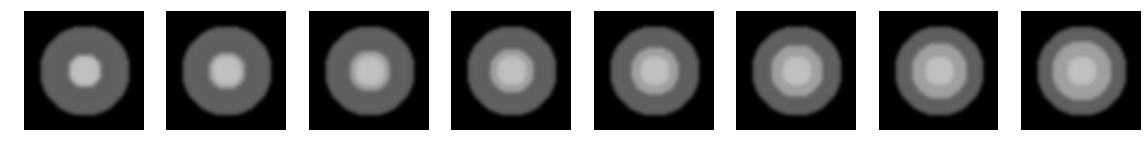

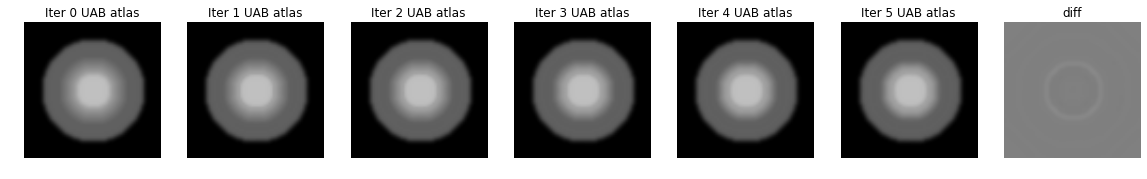

In [23]:
plt.figure(figsize=(20,10)) 
for i in range(num_of_data):
        fn = data_folder+'/healthySimu'+str(i)+'.nrrd'
        im_array = getImageArray(fn)
        plt.subplot(1,num_of_data,i+1)
        implot = plt.imshow(im_array,cm.gray,vmin = 0, vmax = 80) 
        plt.axis('off')  
        iter0Fn = GT_UAB_result_folder+'/Iter0_'+str(i)+'.nrrd'
        im = sitk.GetImageFromArray(im_array)
        sitk.WriteImage(im,iter0Fn)
        
runUAB(GT_UAB_result_folder)


iter1
iter2
iter3
iter4
iter5
max = 6.05642080307
min = -1.41434383392
total ssd =  4268.62229871
lamda =  1.0
iter1
[iter: 0000]: rank(P) = 0001, |C|_0 = 0000, crit=0.0883790835, total sparse =0000
[iter: 0010]: rank(P) = 0005, |C|_0 = 1512, crit=0.0036427275, total sparse =2871
[iter: 0020]: rank(P) = 0008, |C|_0 = 2804, crit=0.0000434365, total sparse =3120
RPCA takes:0.147083 seconds
iter2
[iter: 0000]: rank(P) = 0001, |C|_0 = 0000, crit=0.0245301344, total sparse =0000
[iter: 0010]: rank(P) = 0003, |C|_0 = 0786, crit=0.0076539000, total sparse =0934
[iter: 0020]: rank(P) = 0008, |C|_0 = 2379, crit=0.0000030668, total sparse =1288
RPCA takes:0.175267 seconds
iter3
[iter: 0000]: rank(P) = 0001, |C|_0 = 0000, crit=0.0120646602, total sparse =0000
[iter: 0010]: rank(P) = 0002, |C|_0 = 0647, crit=0.0062700162, total sparse =0531
[iter: 0020]: rank(P) = 0008, |C|_0 = 2460, crit=0.0000038844, total sparse =0817
RPCA takes:0.235738 seconds
iter4
[iter: 0000]: rank(P) = 0001, |C|_0 = 0000,

/home/fbudin/tutorial-env/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


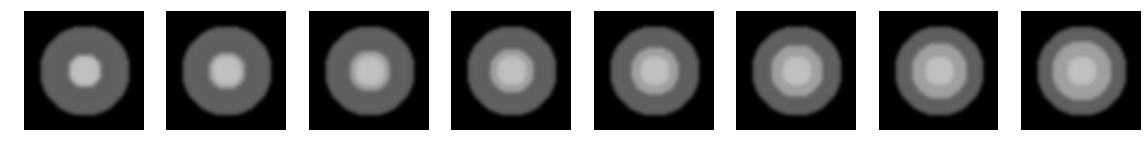

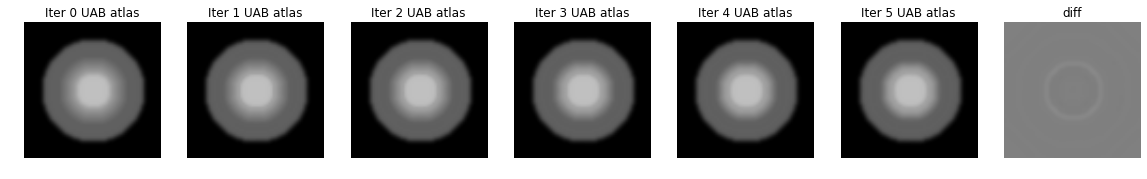

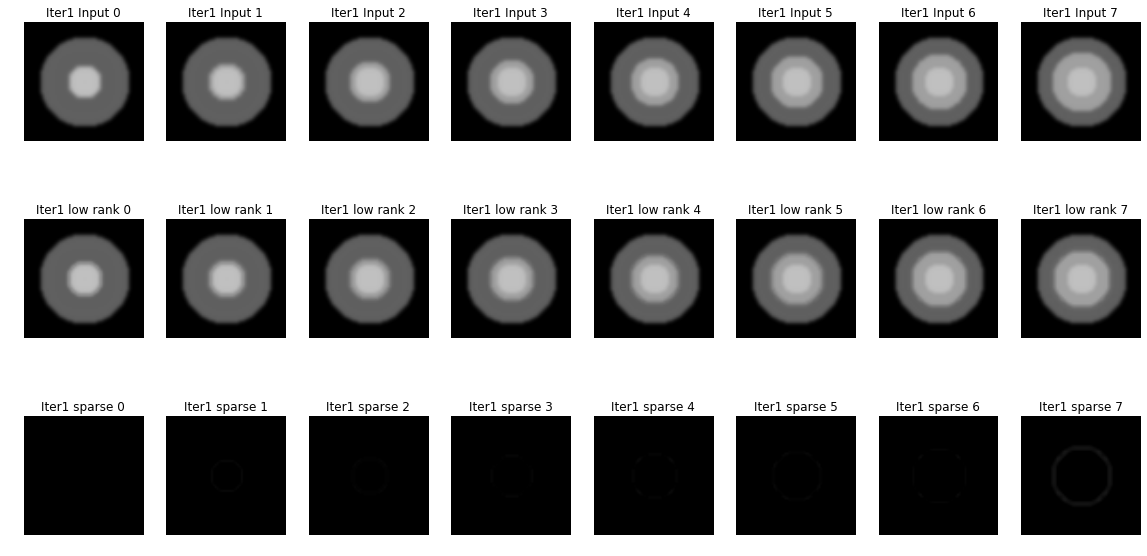

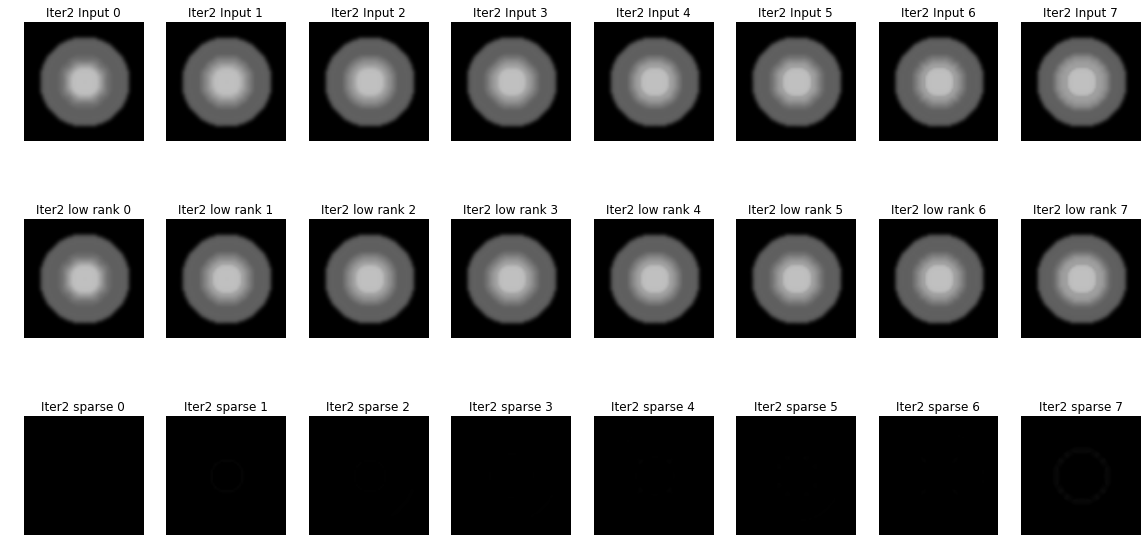

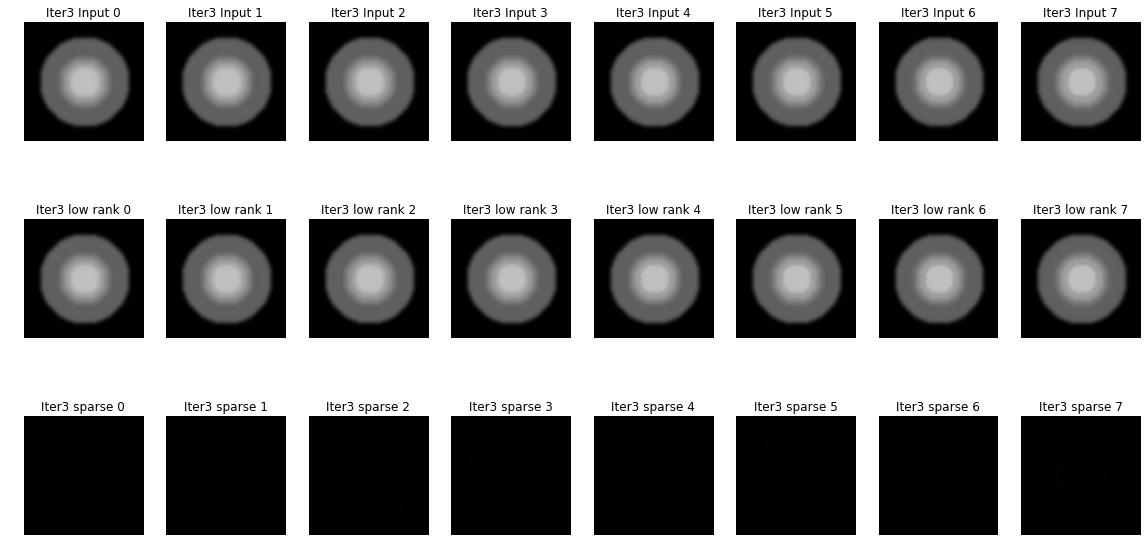

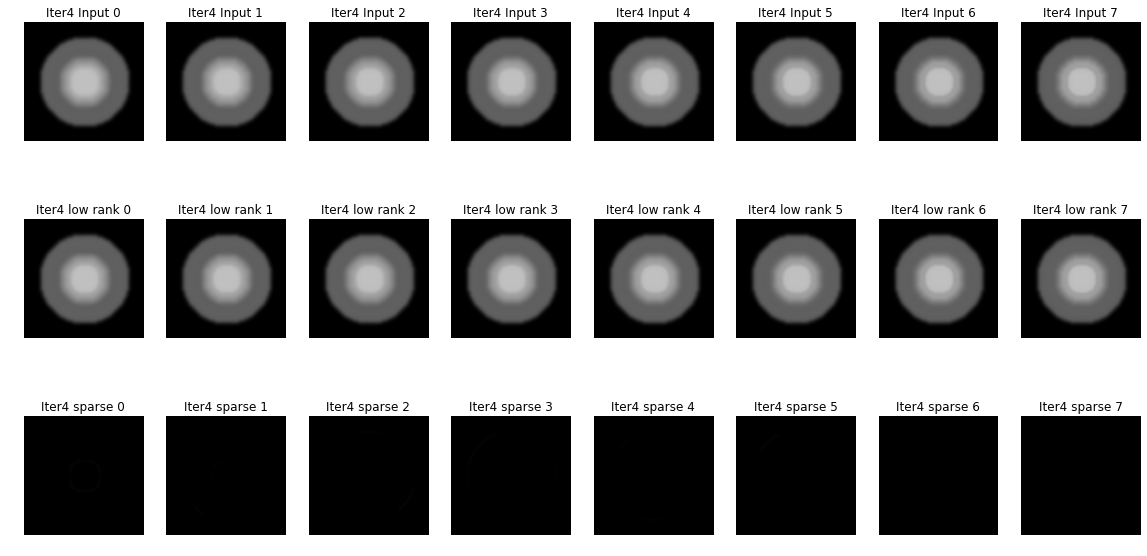

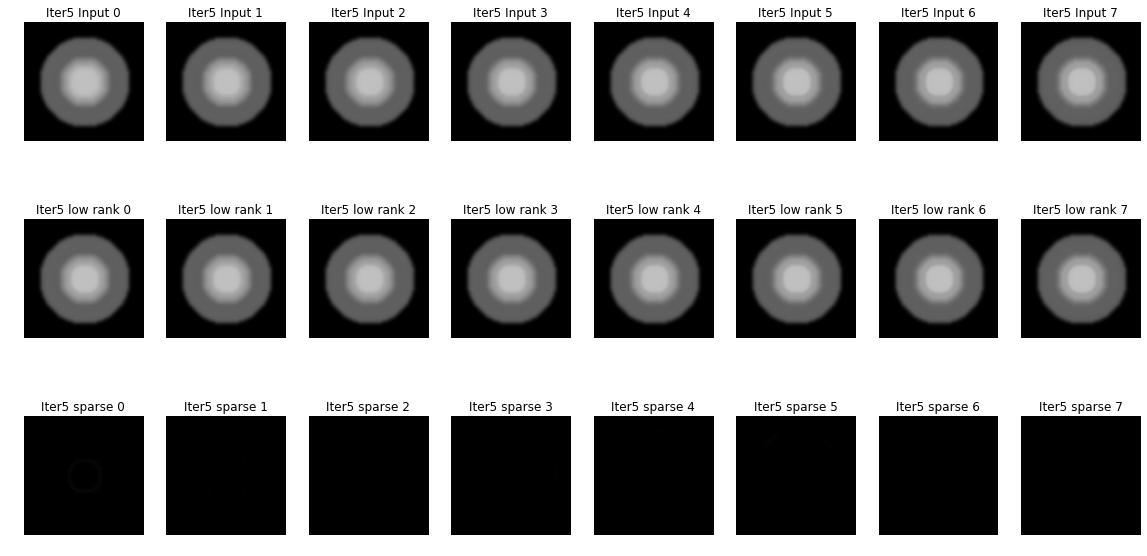

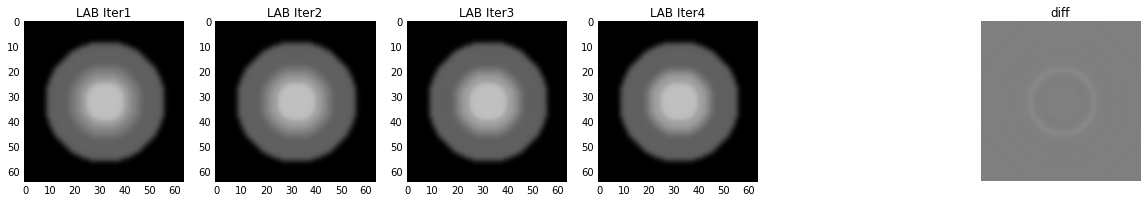

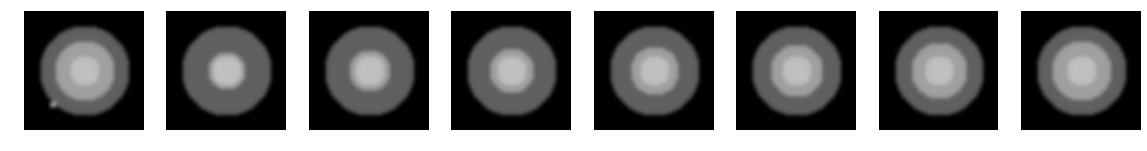

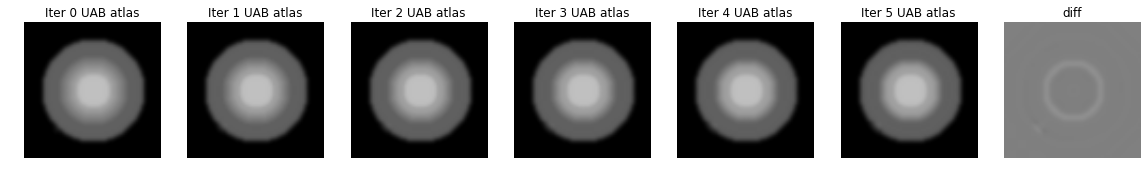

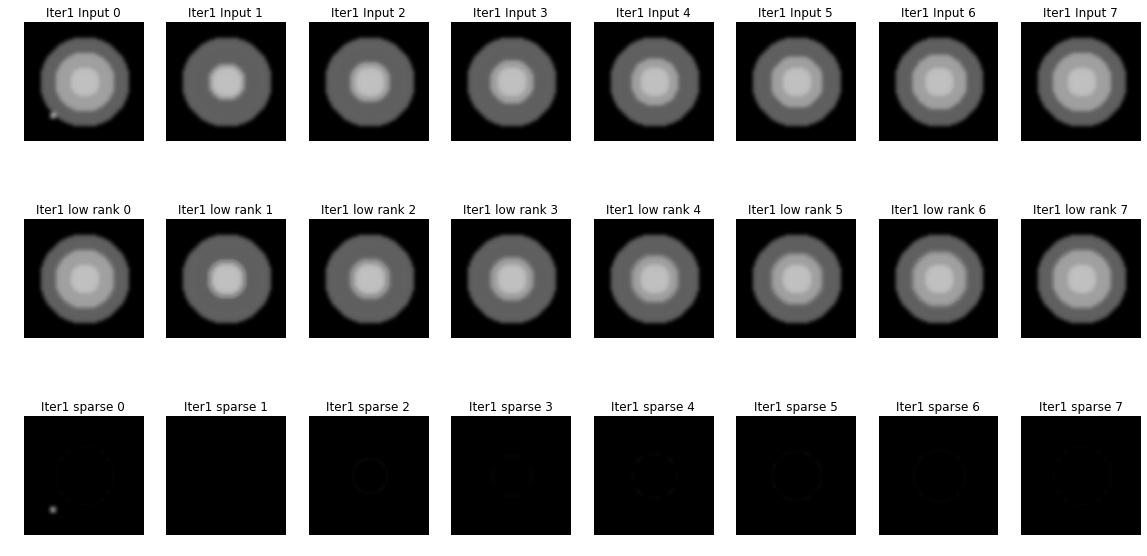

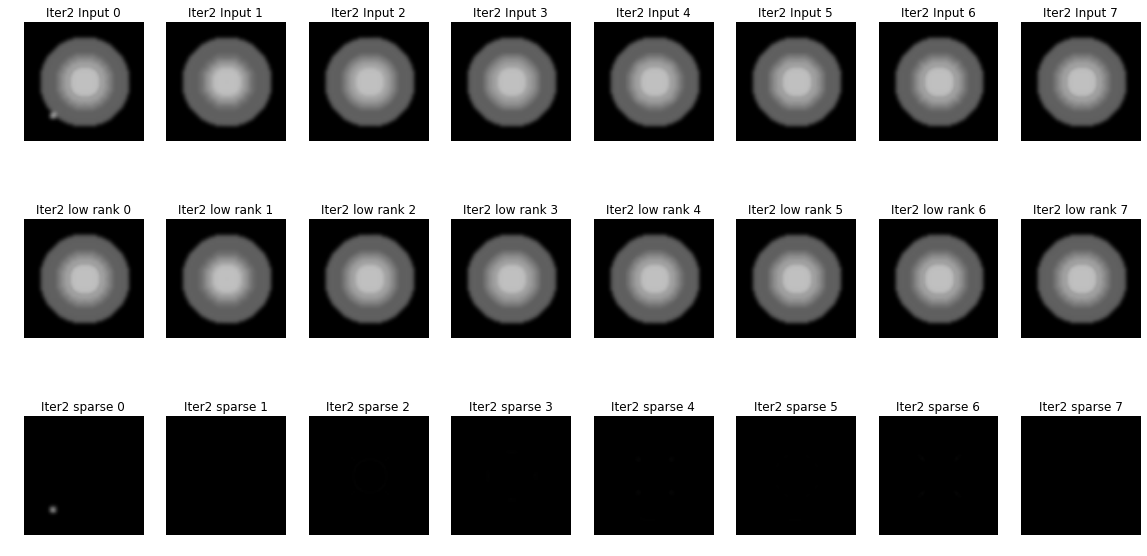

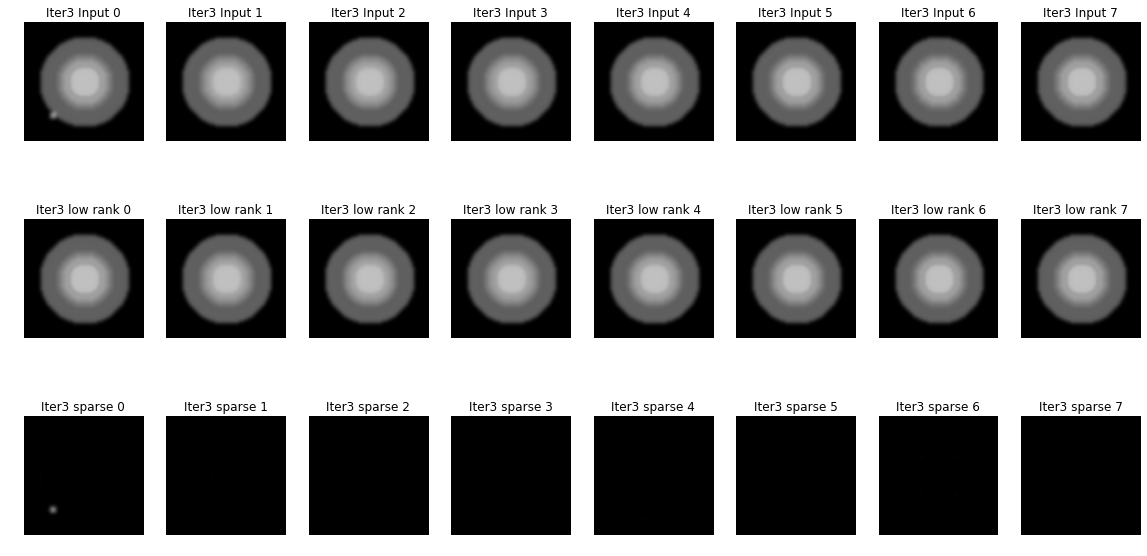

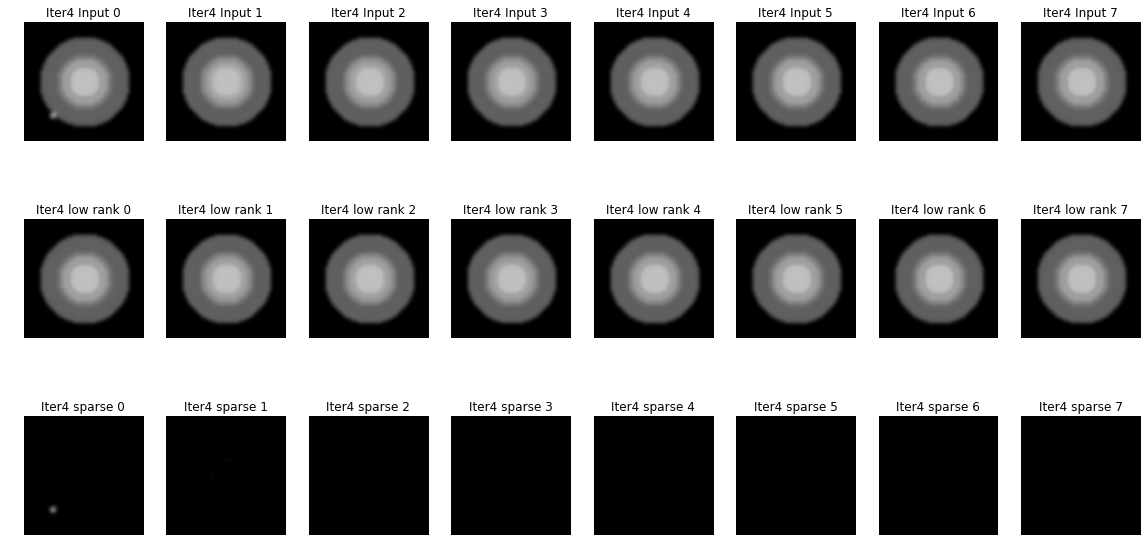

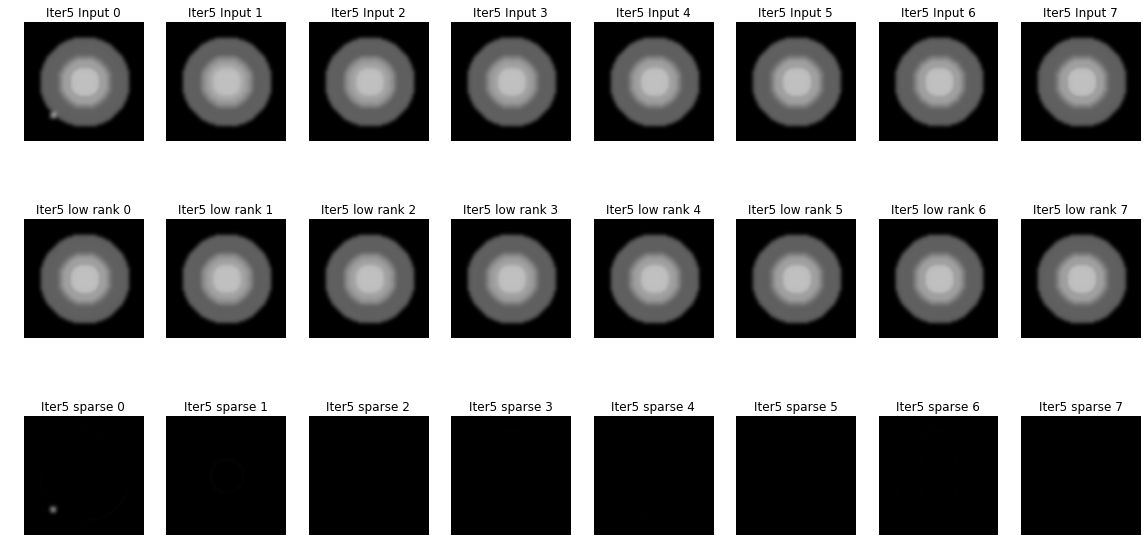

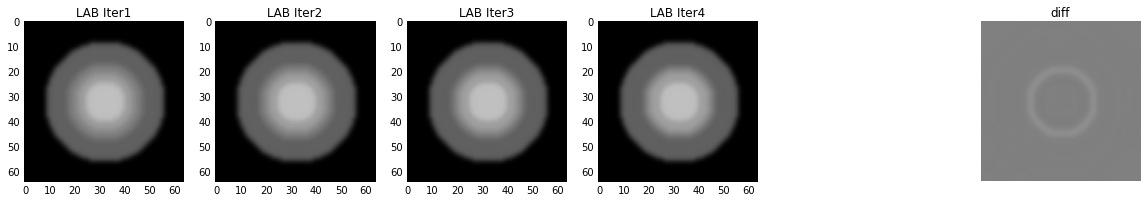

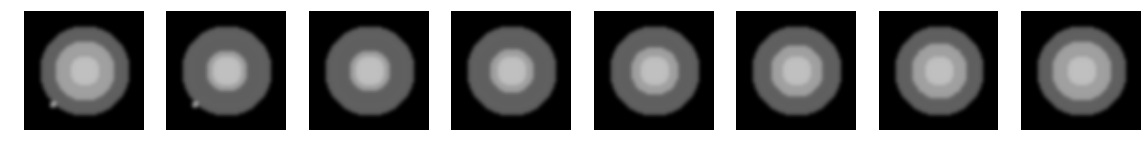

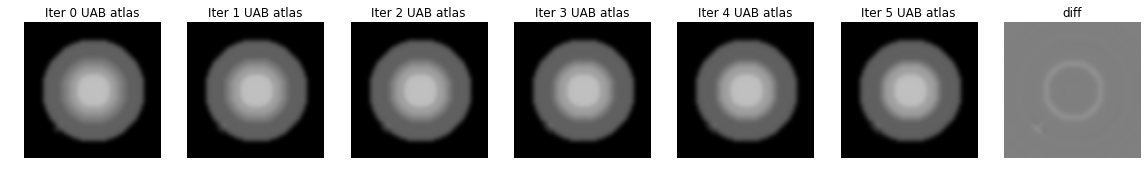

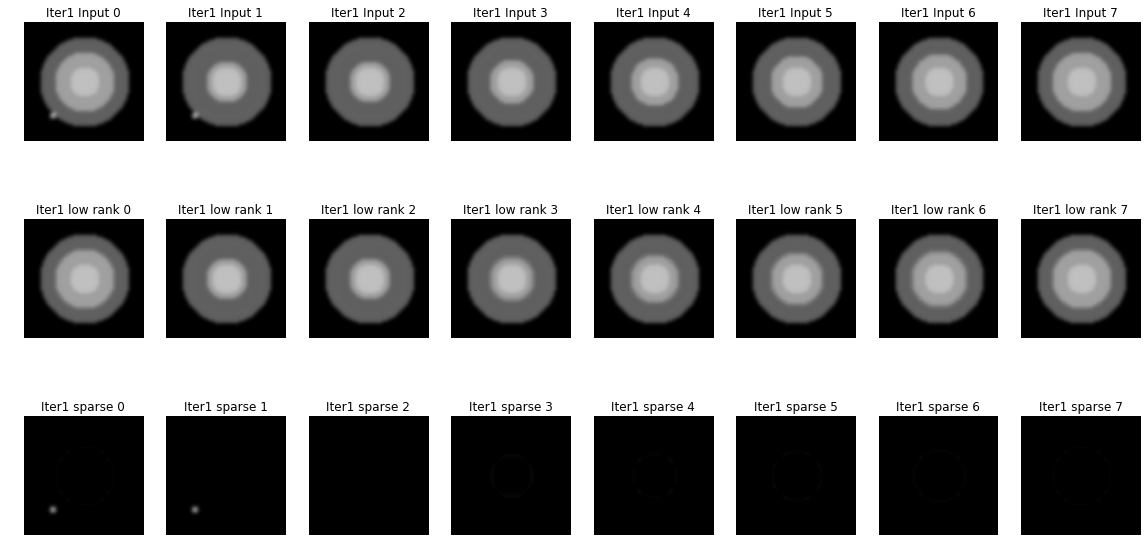

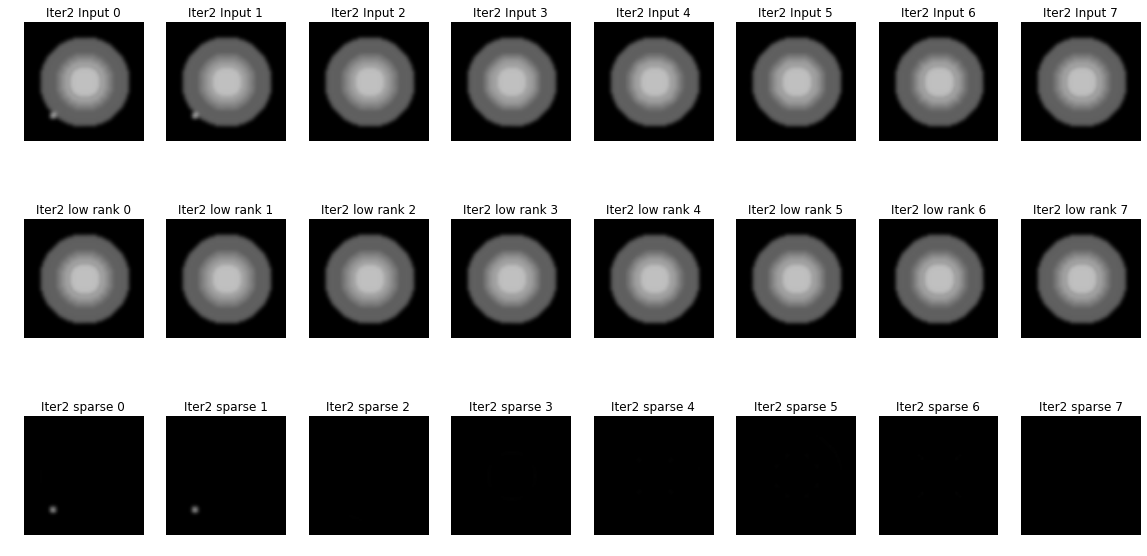

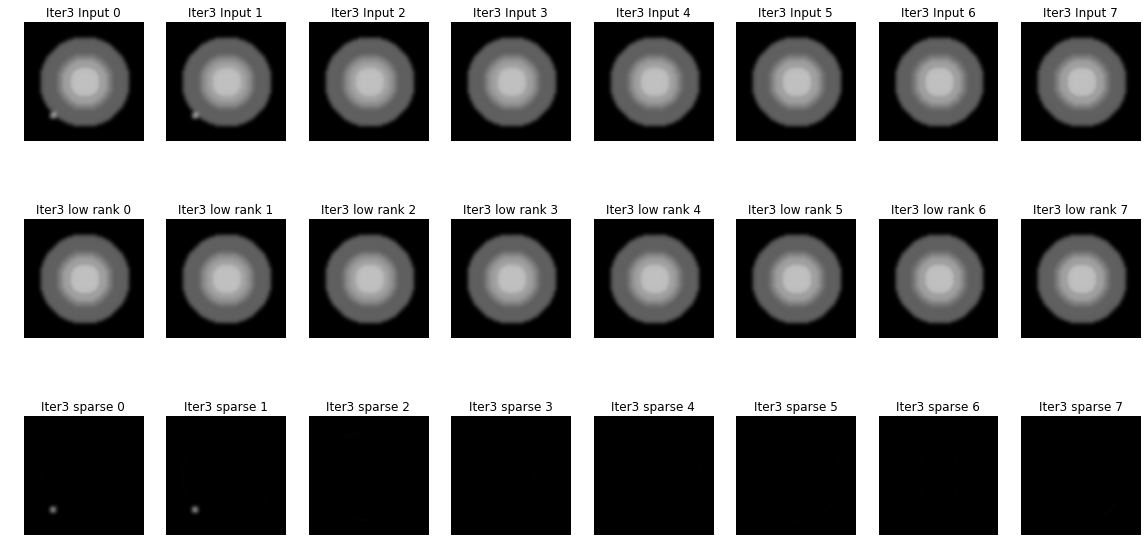

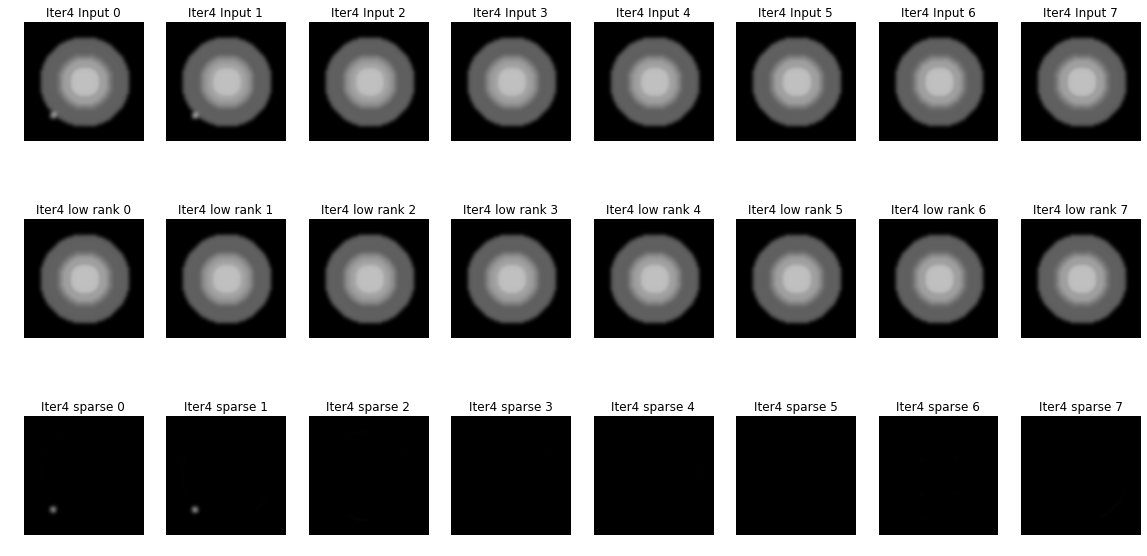

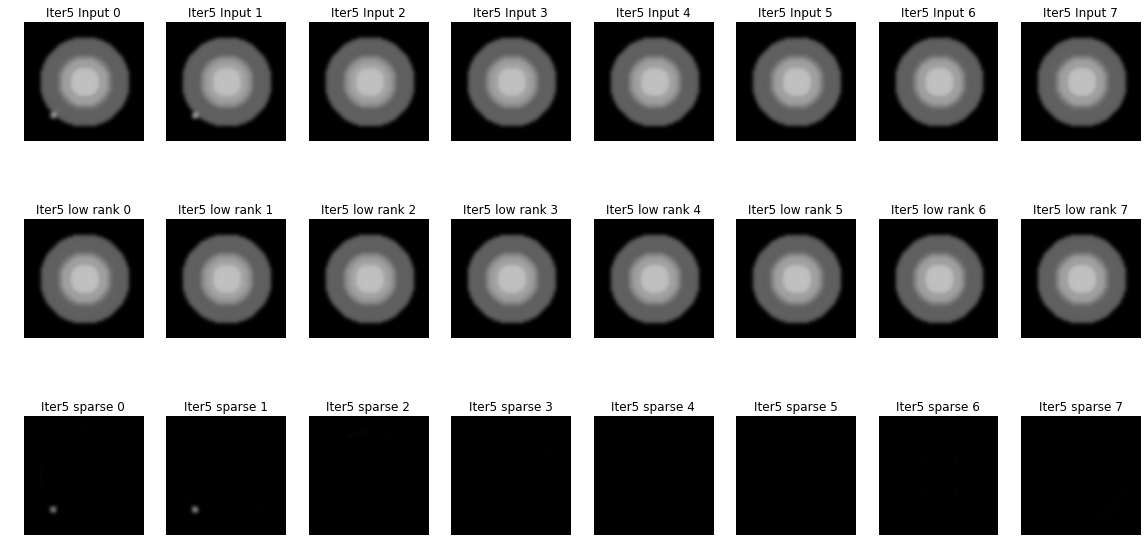

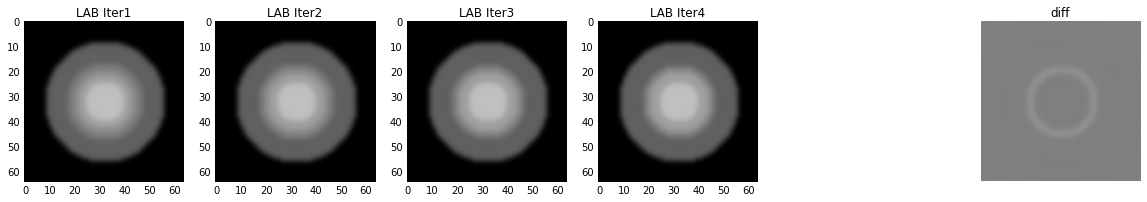

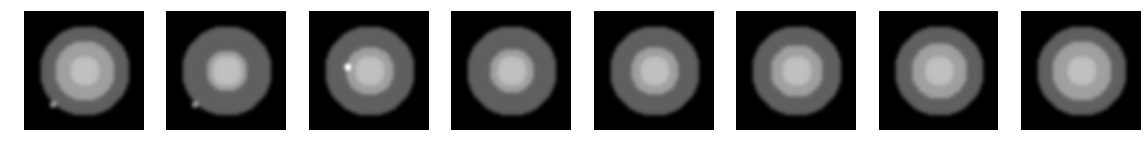

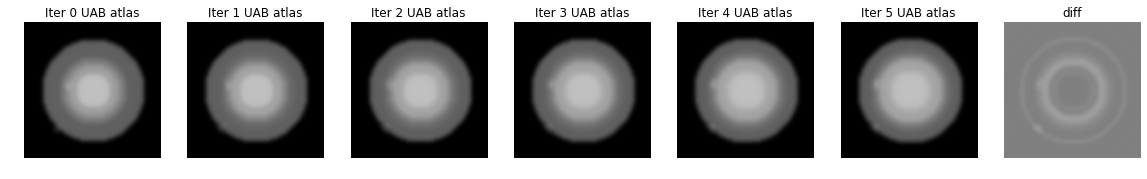

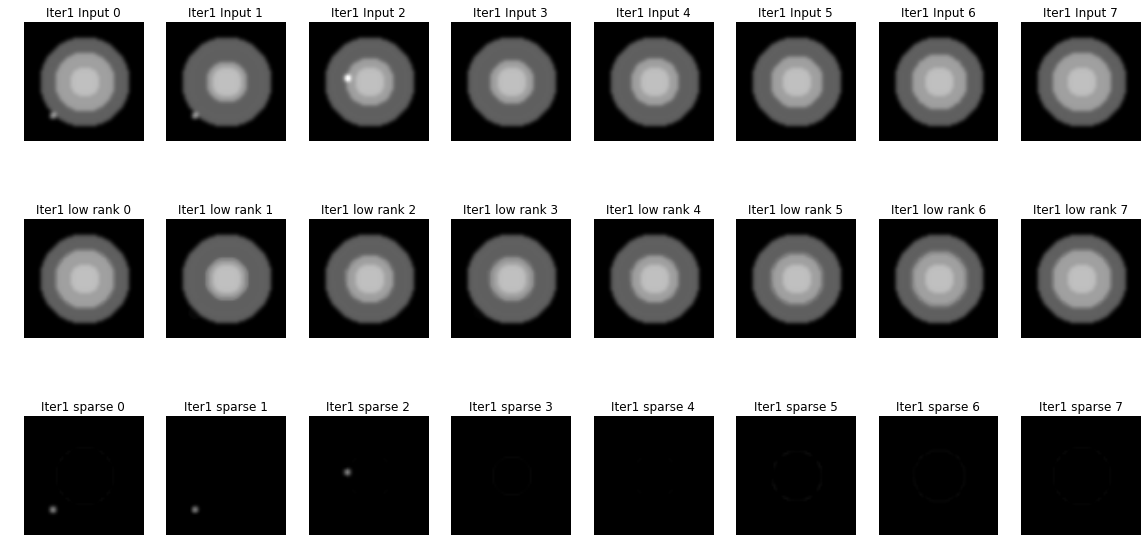

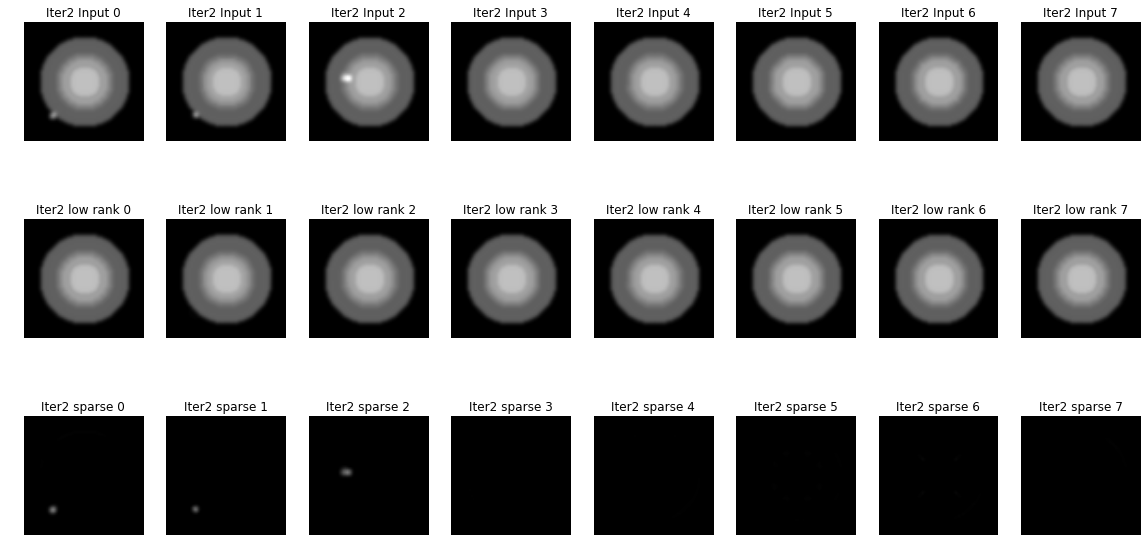

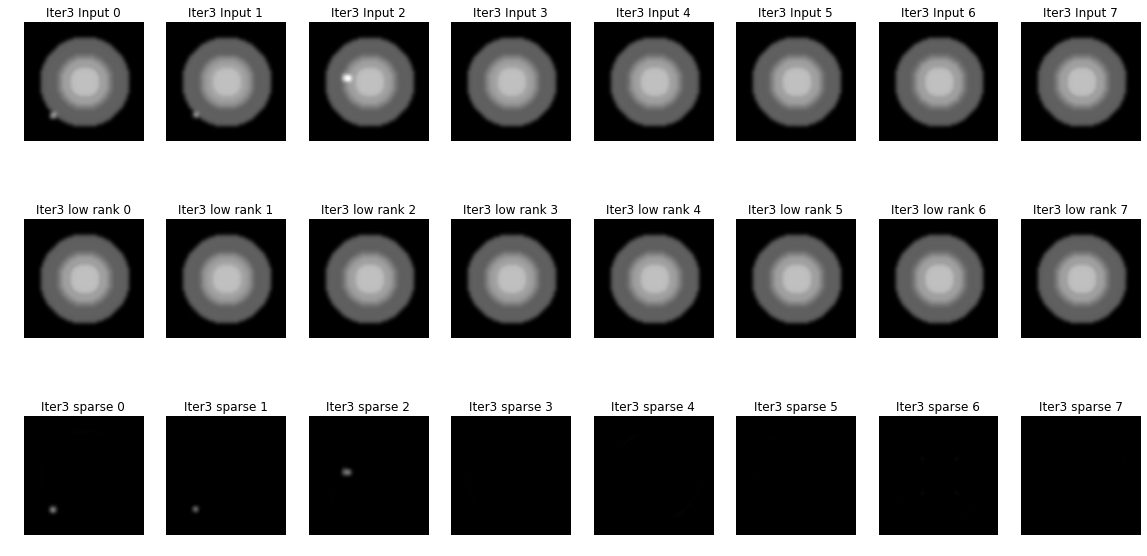

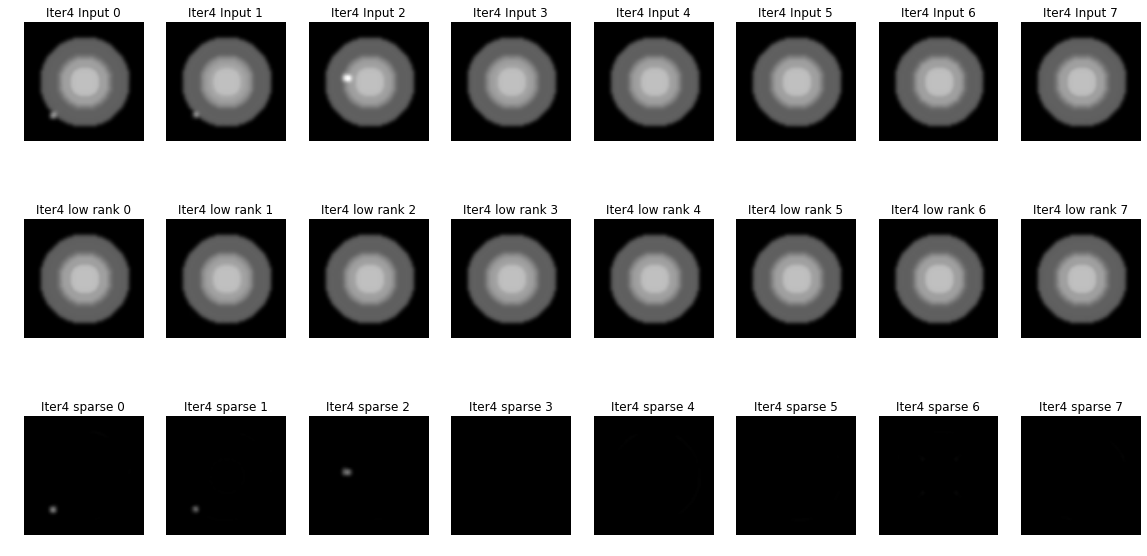

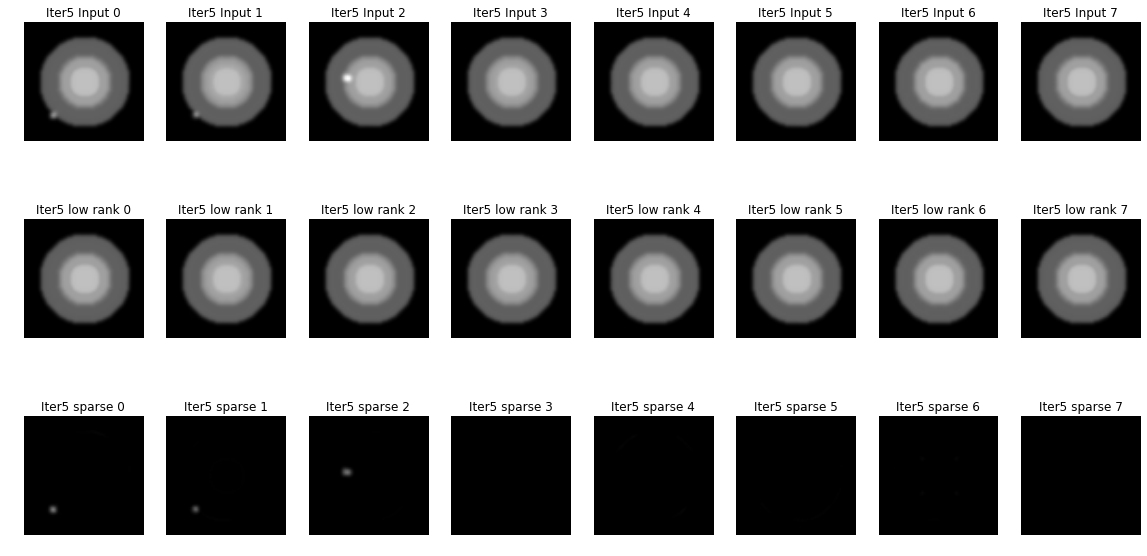

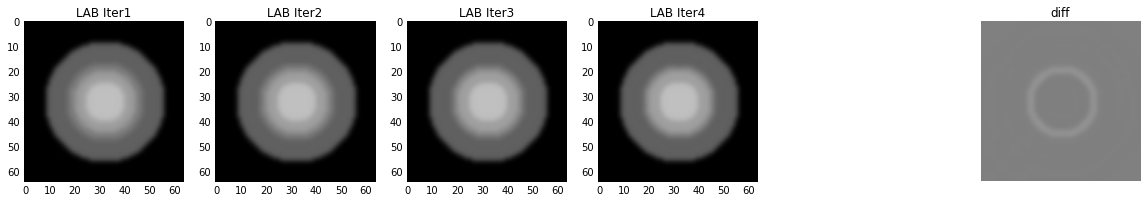

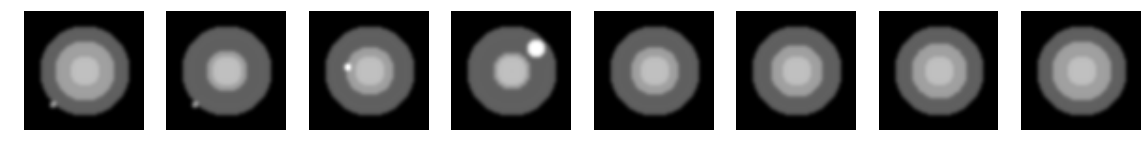

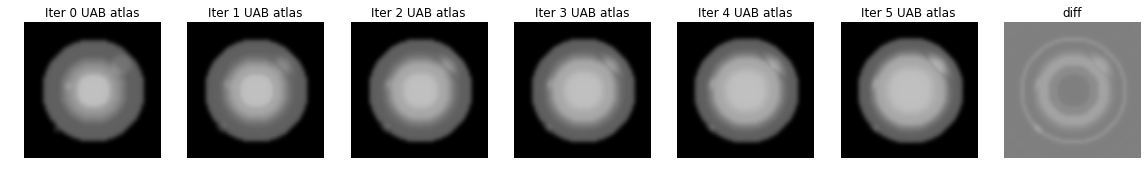

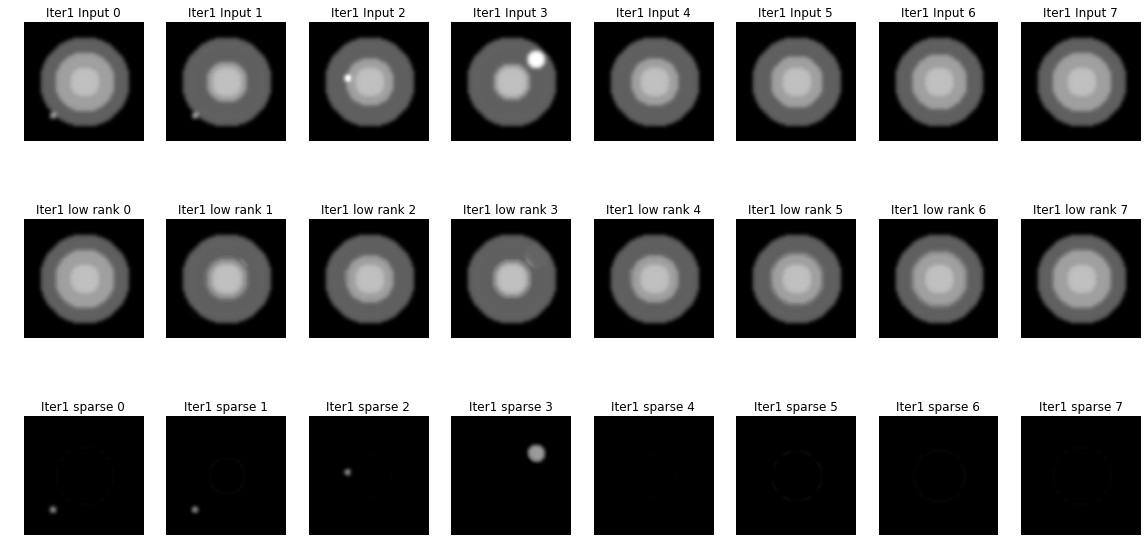

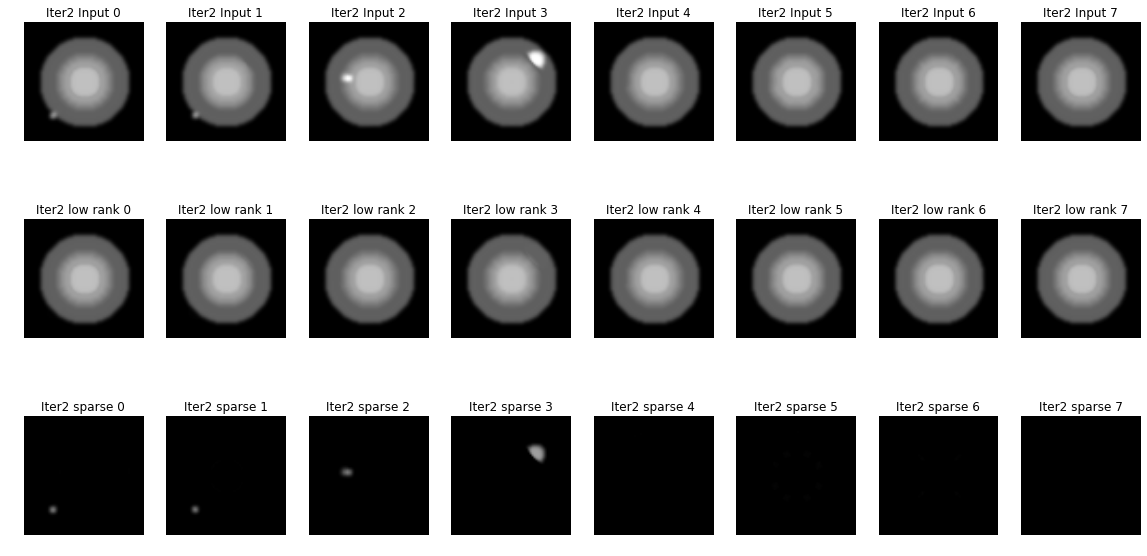

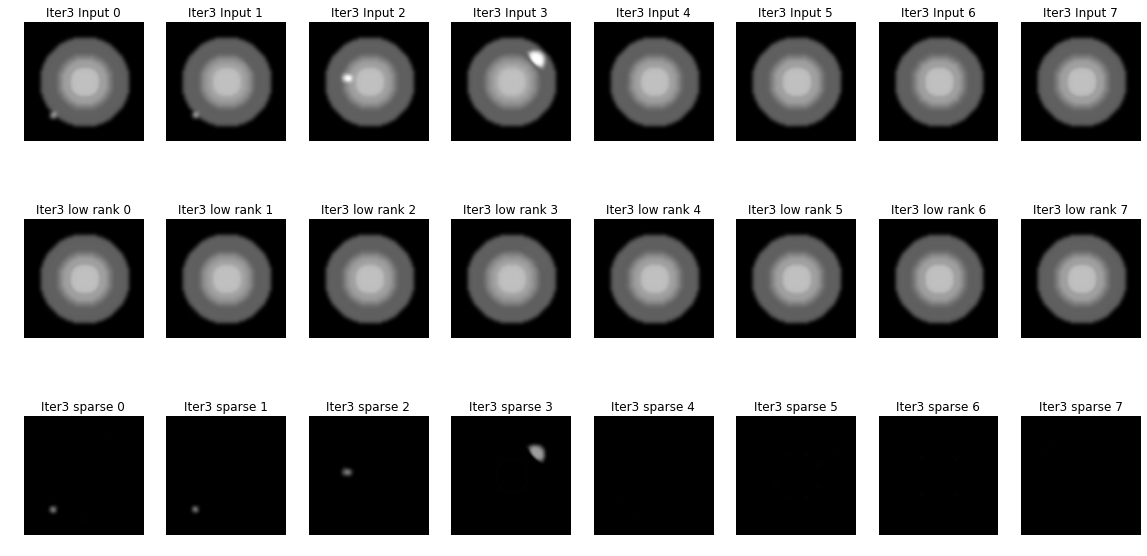

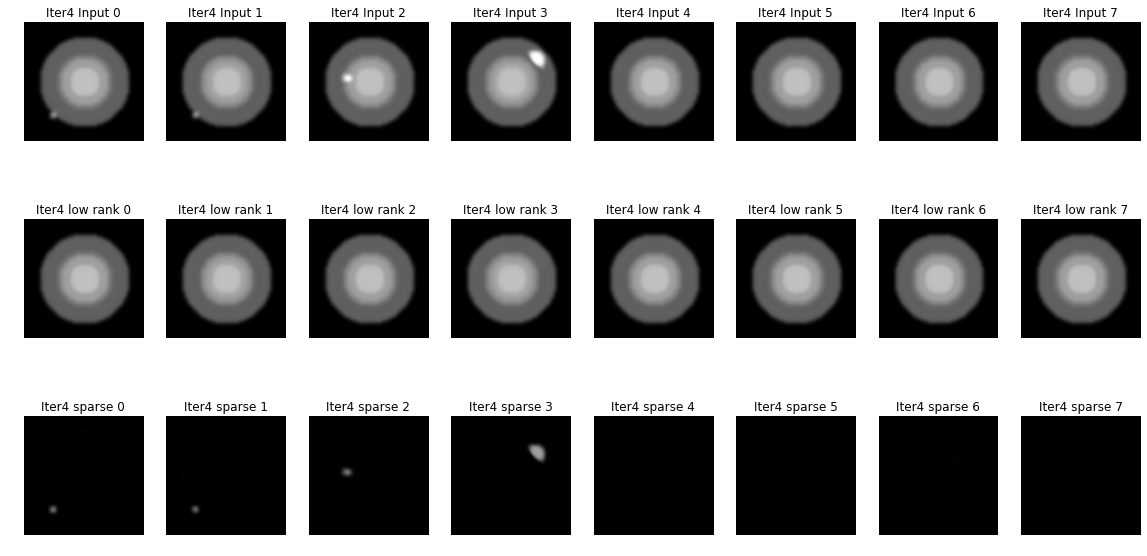

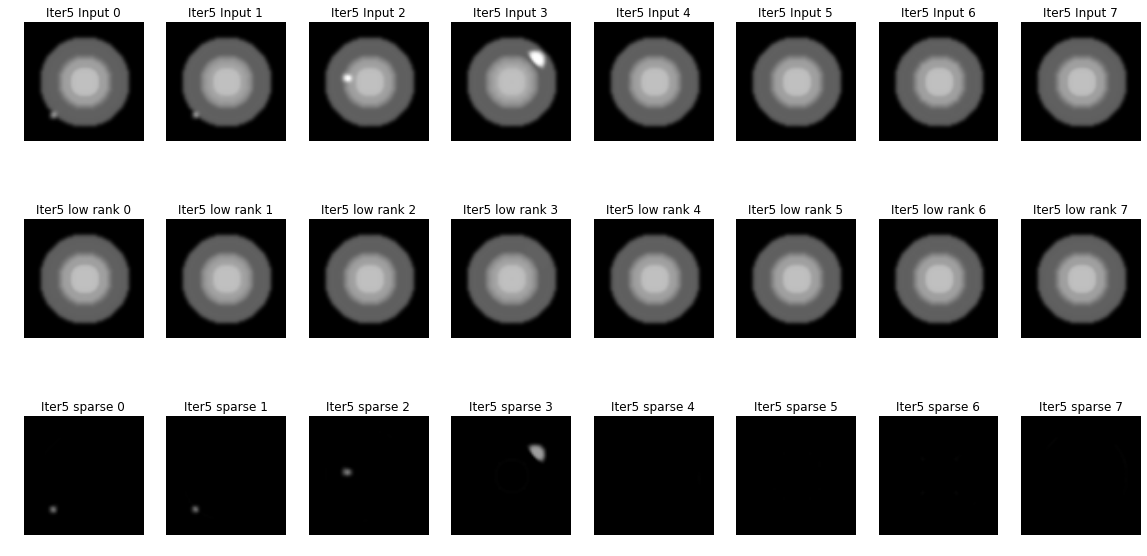

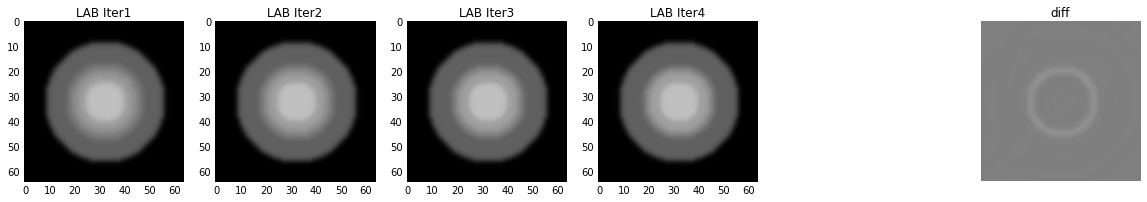

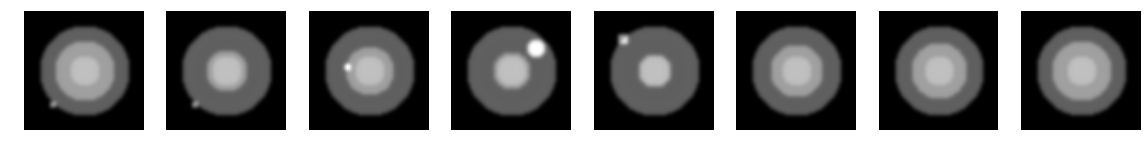

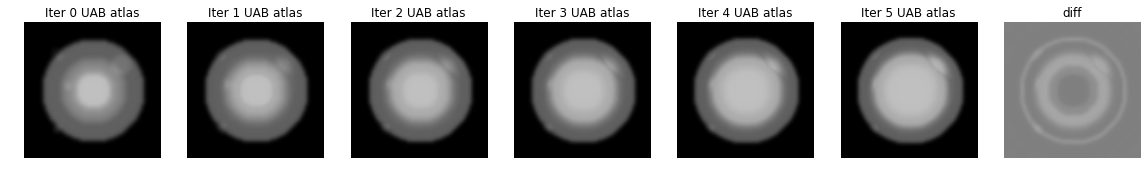

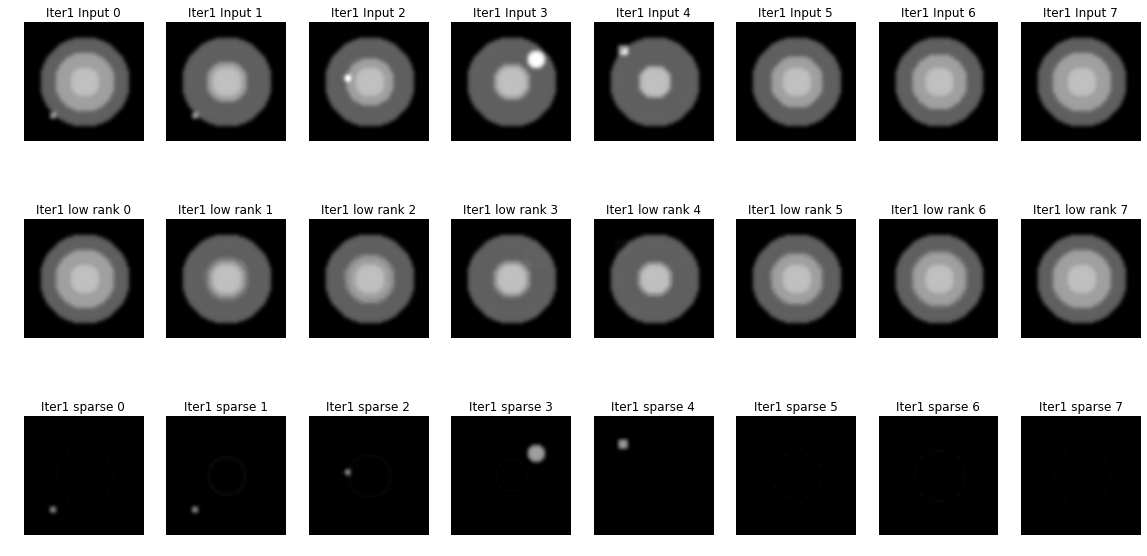

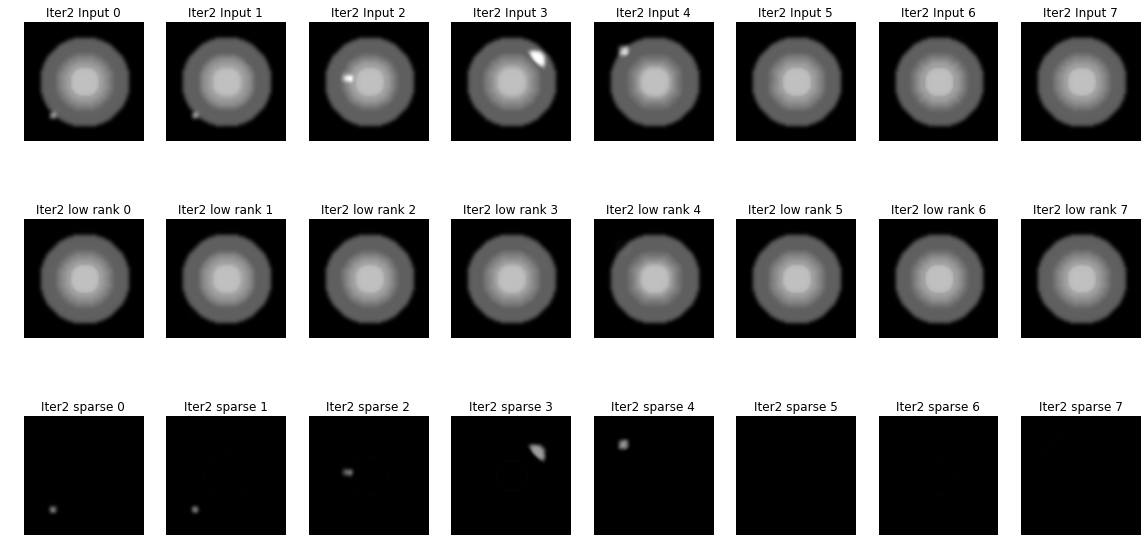

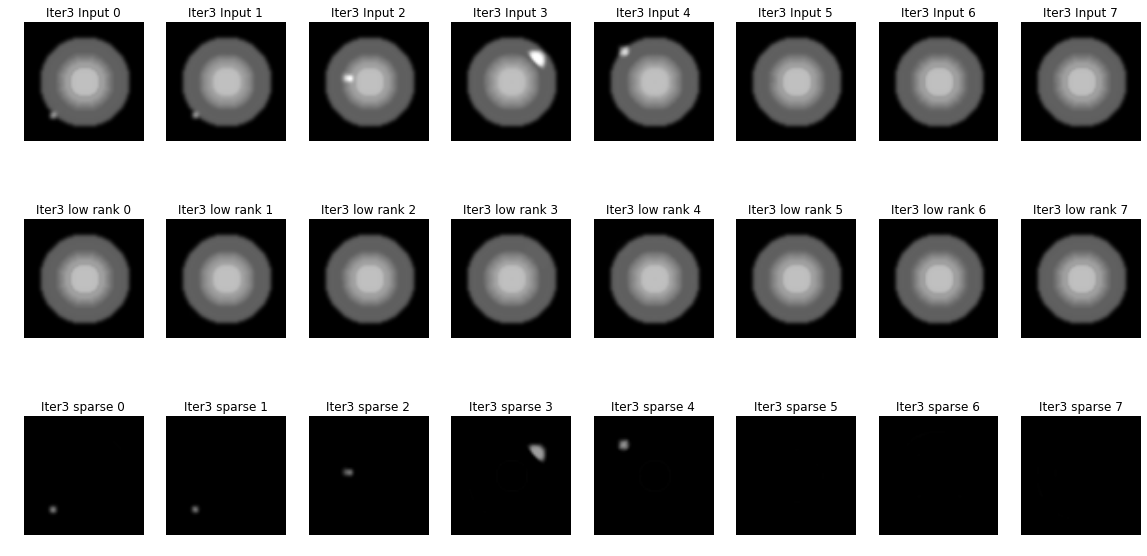

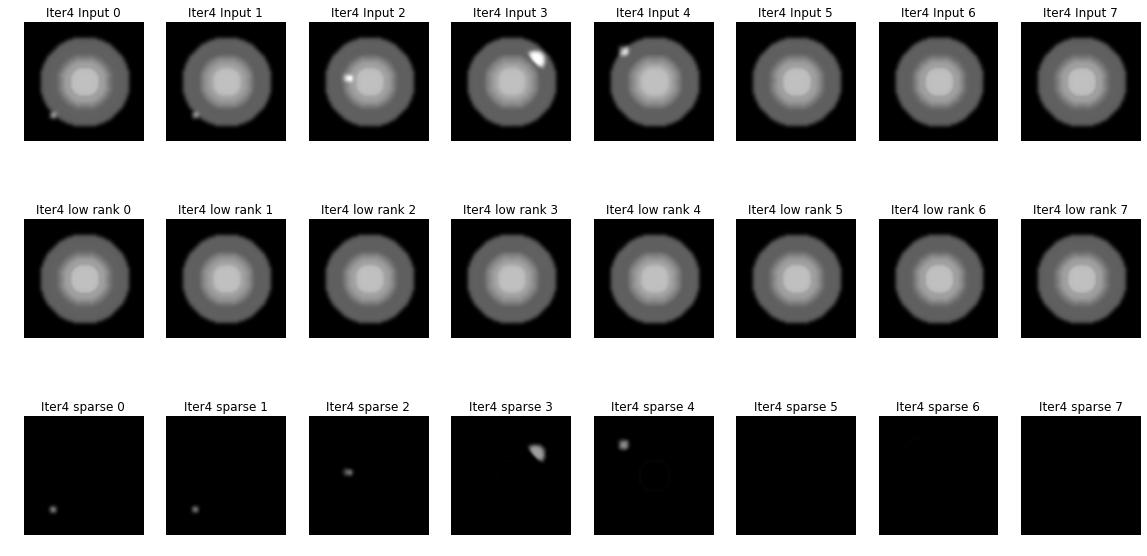

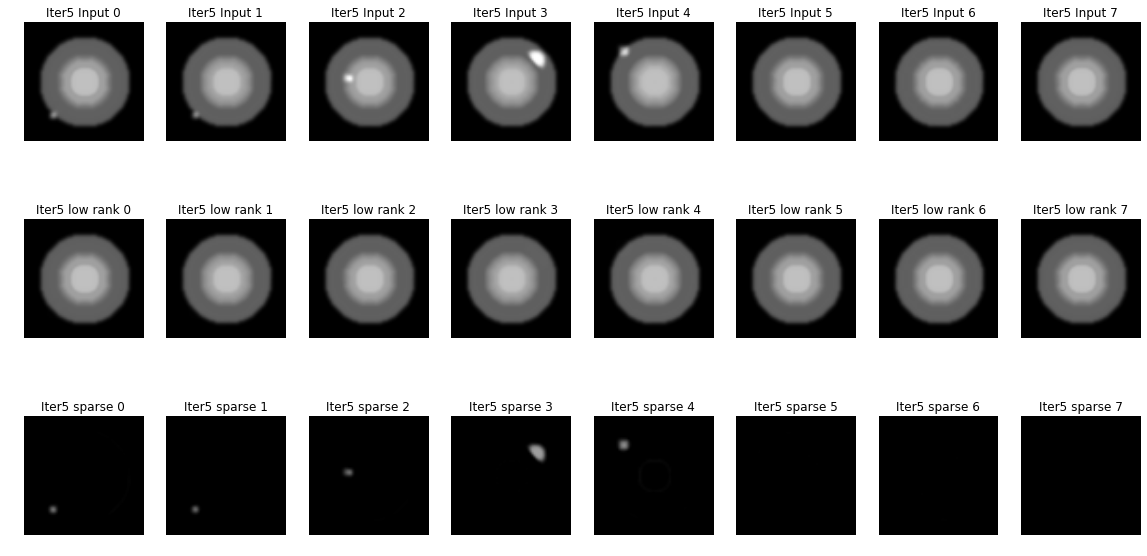

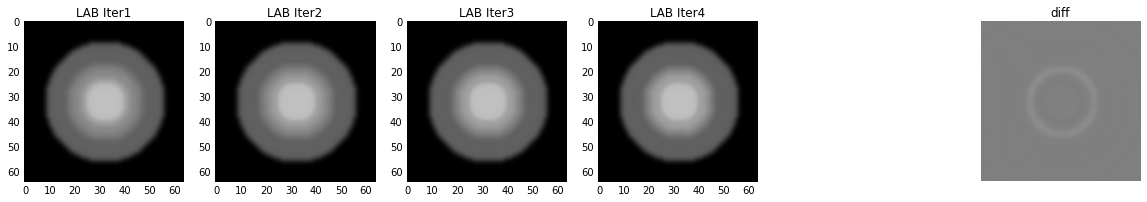

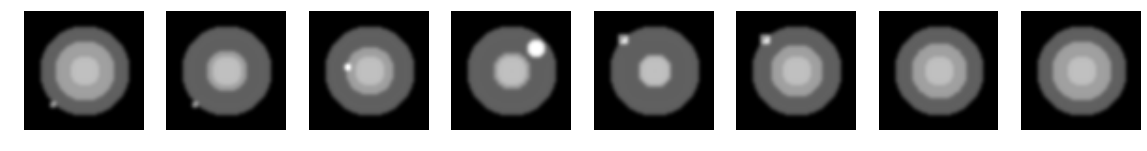

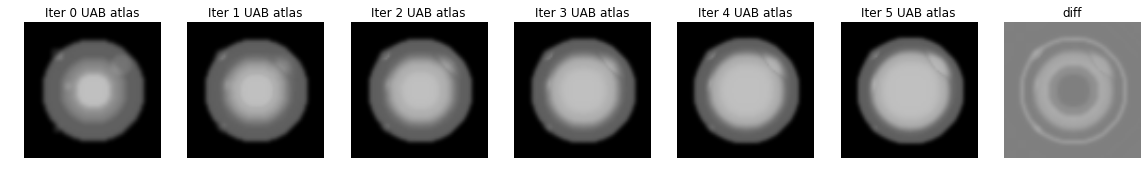

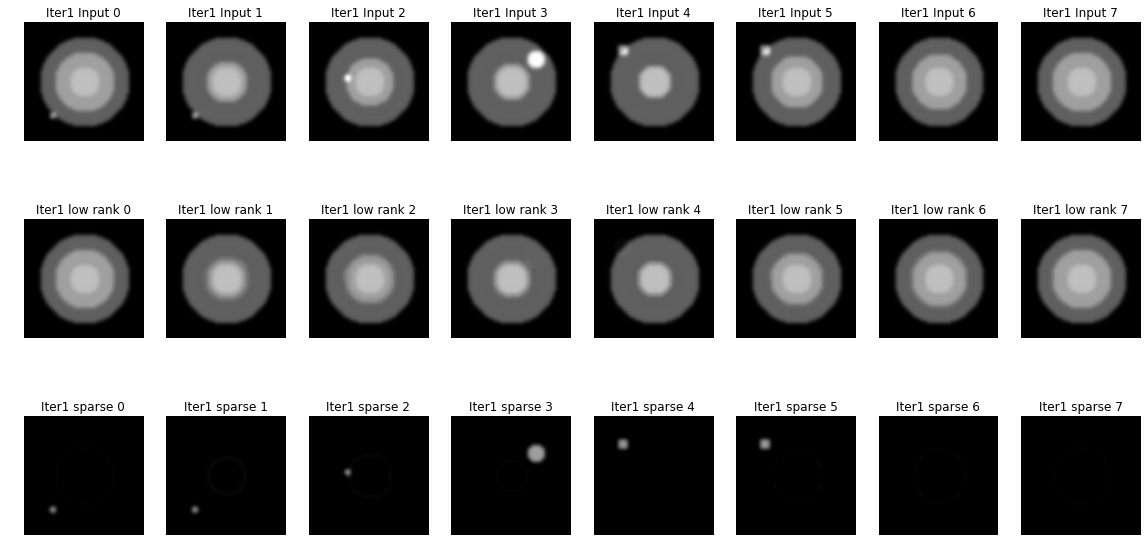

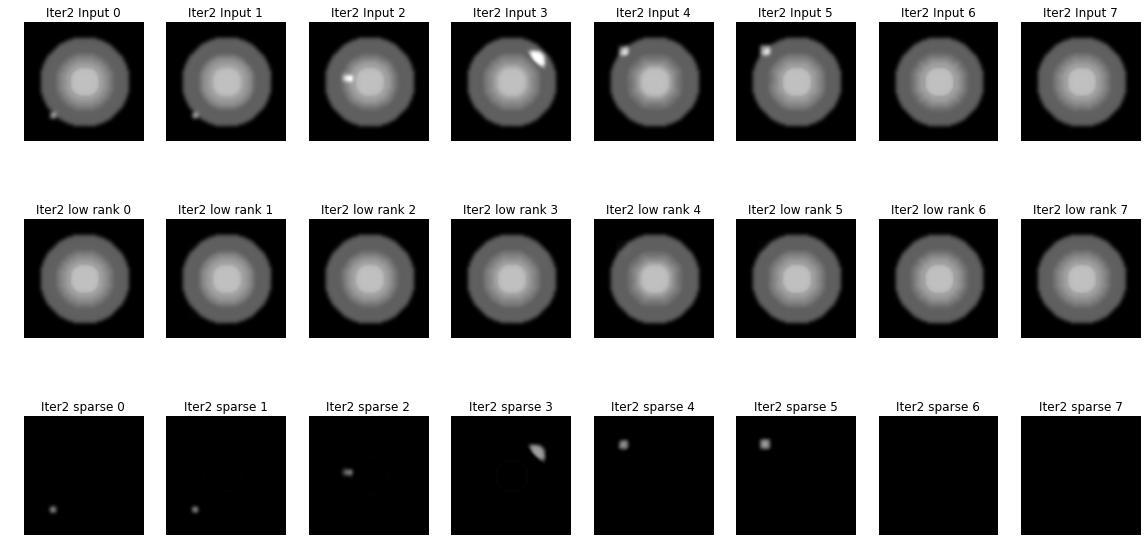

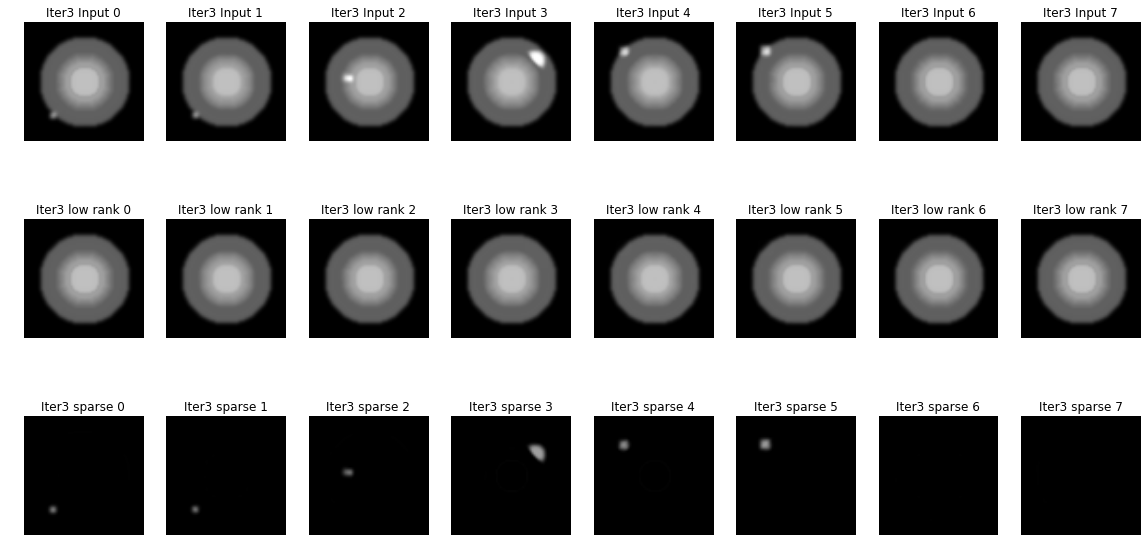

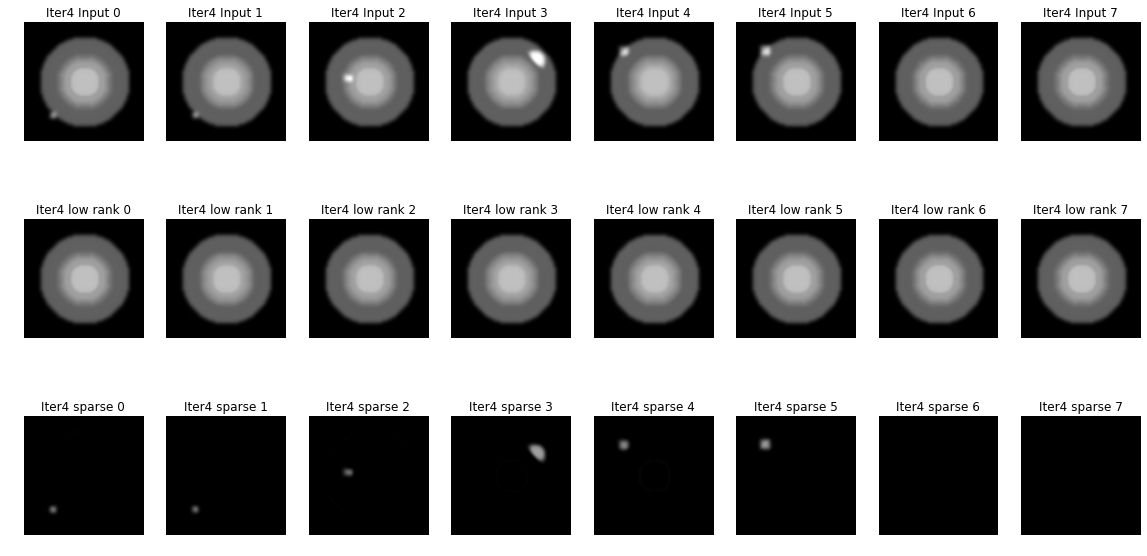

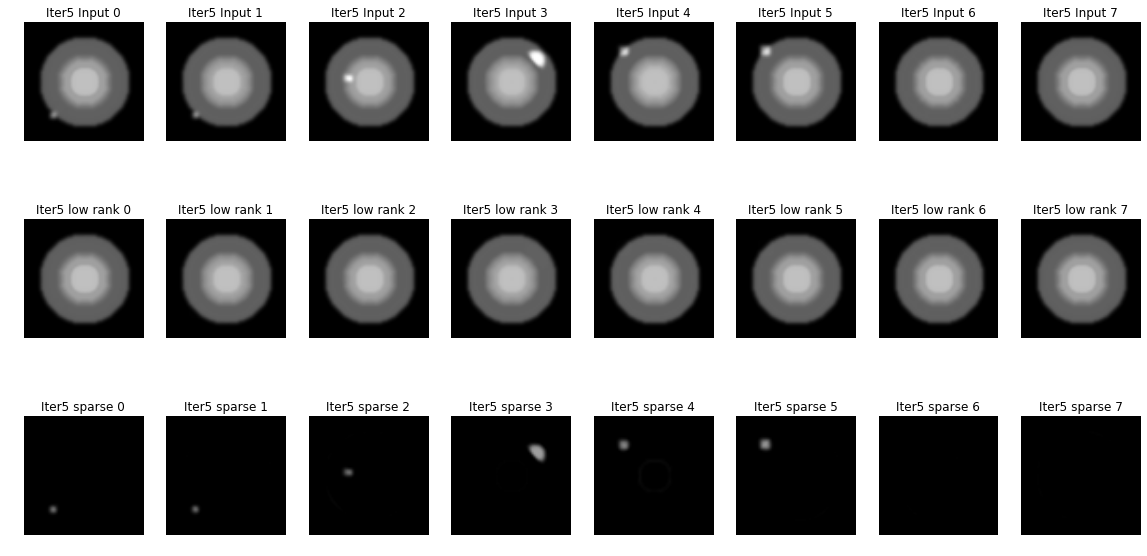

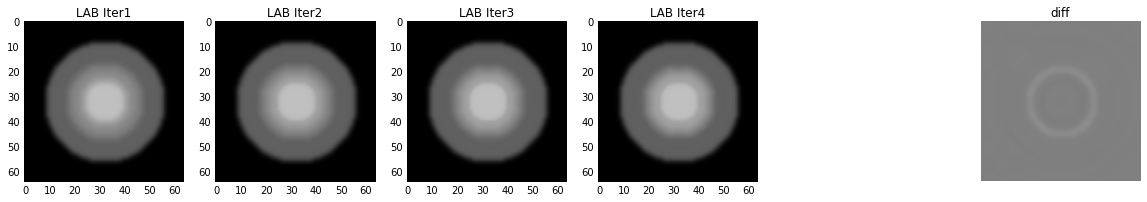

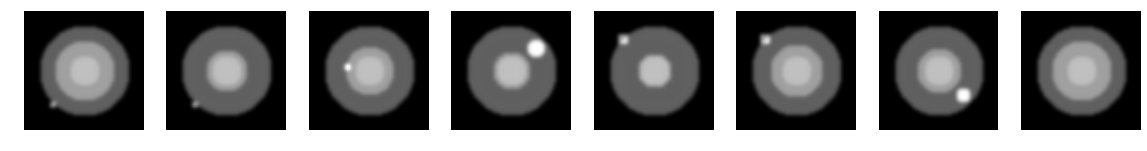

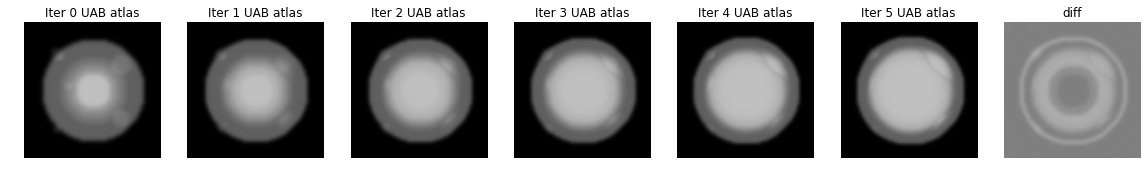

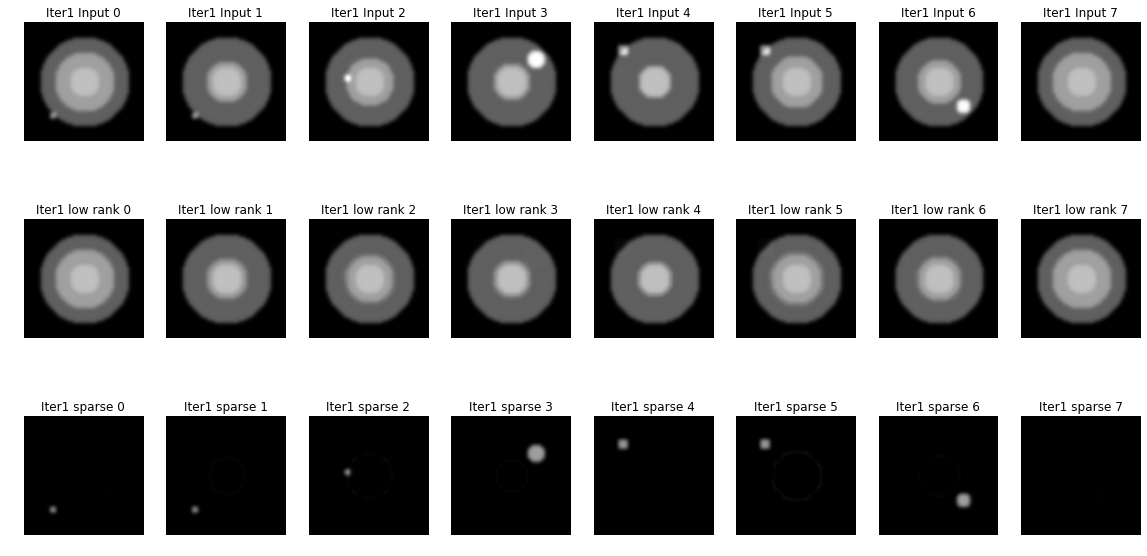

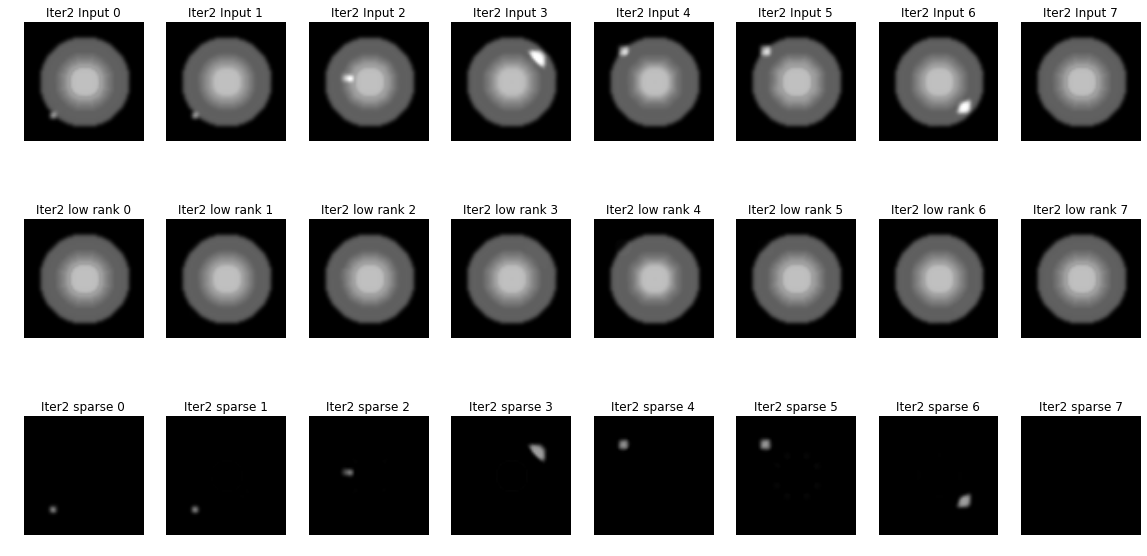

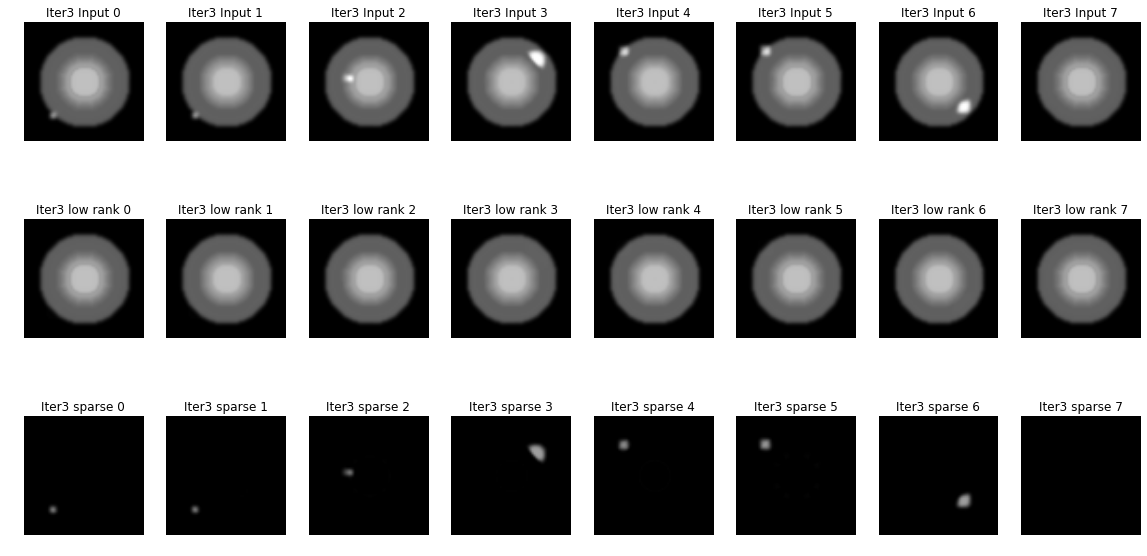

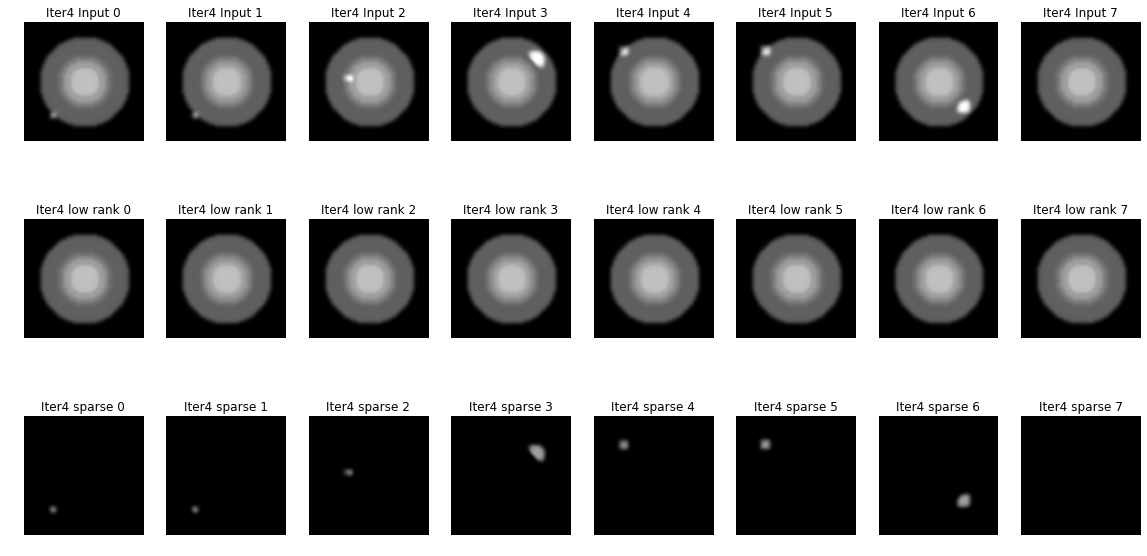

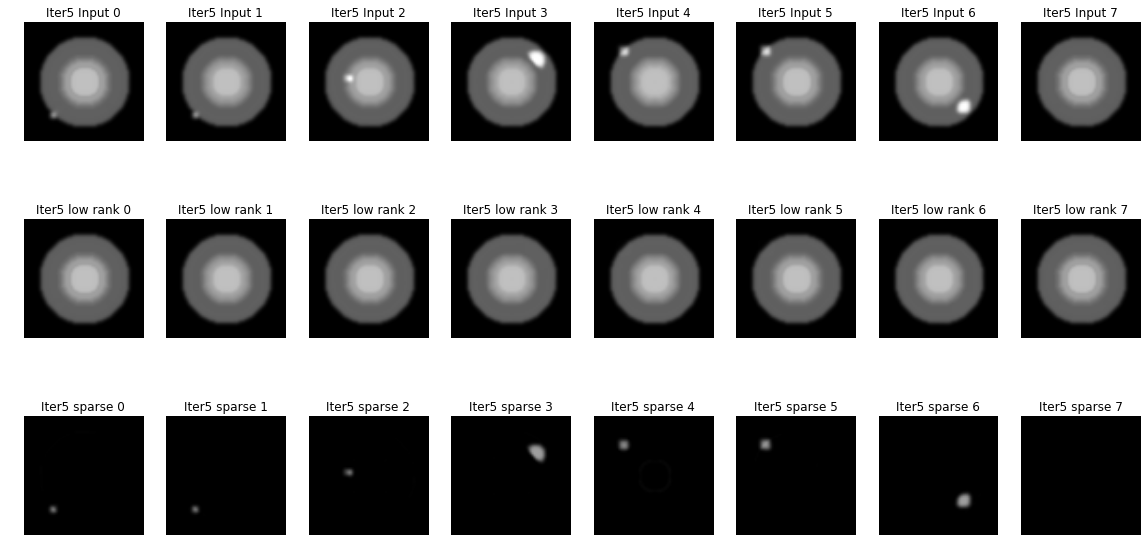

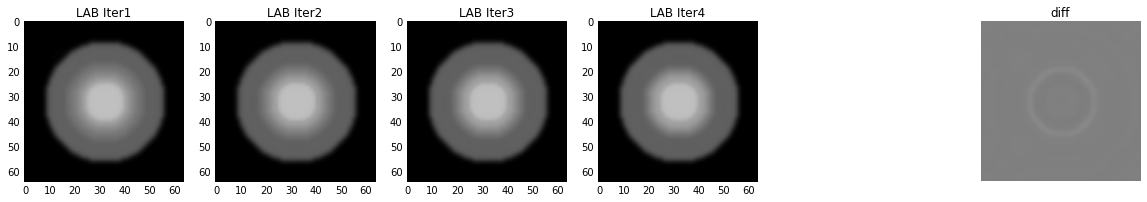

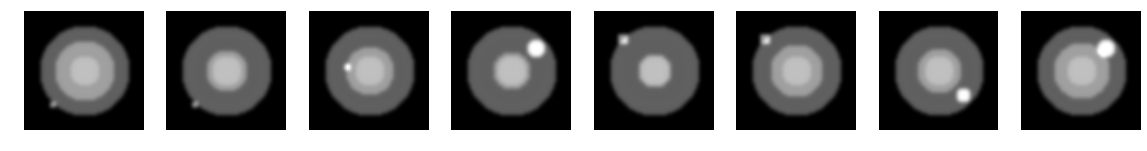

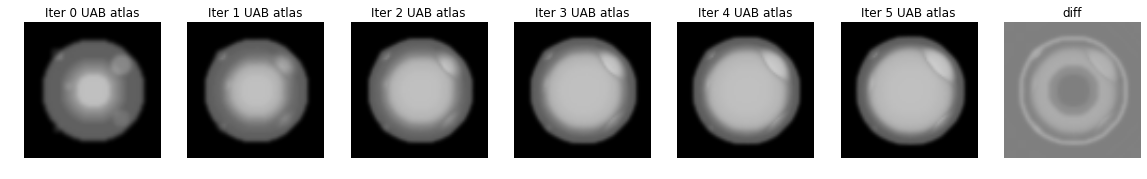

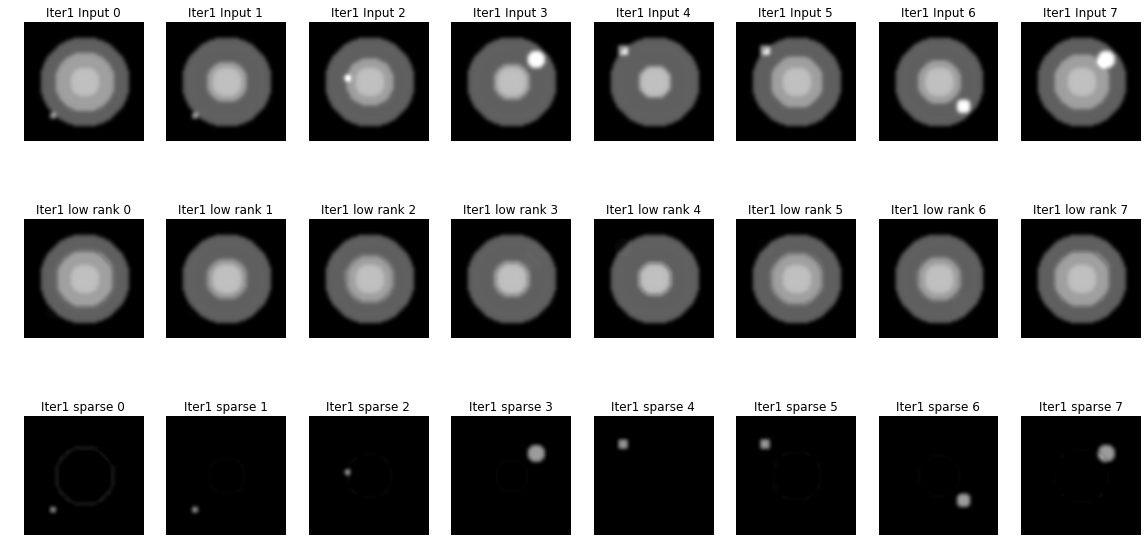

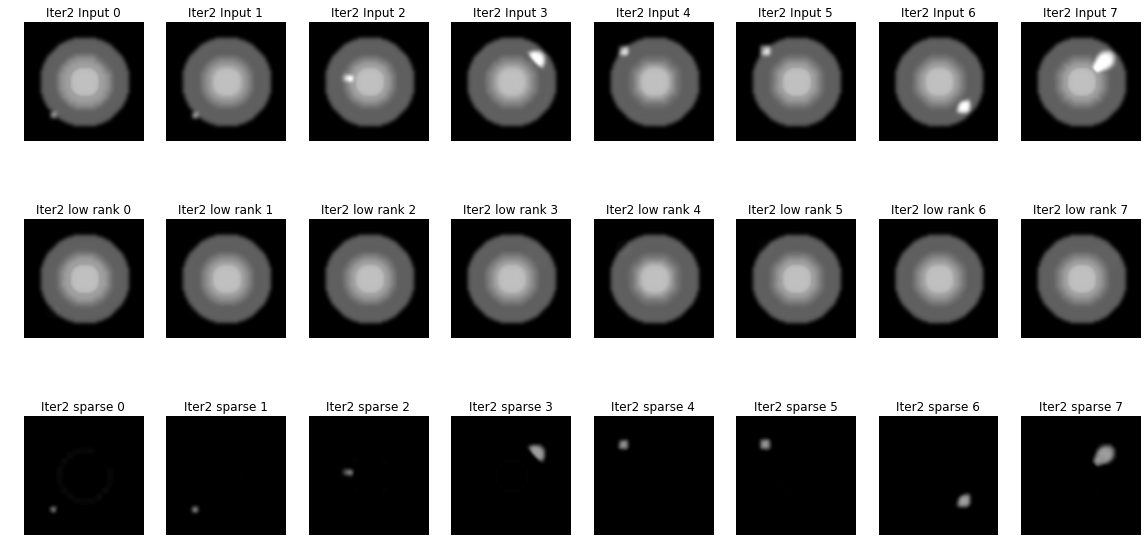

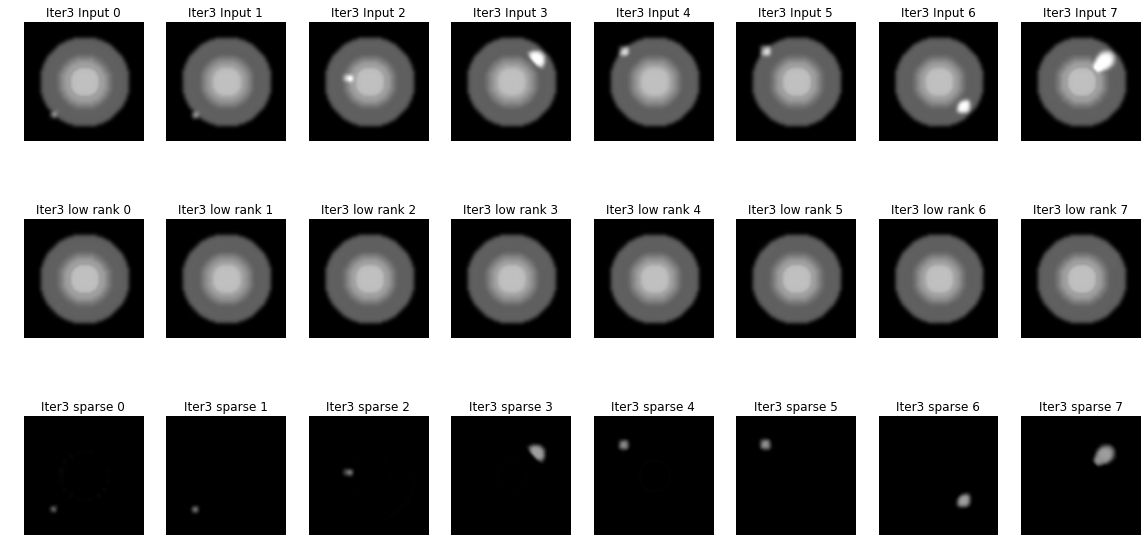

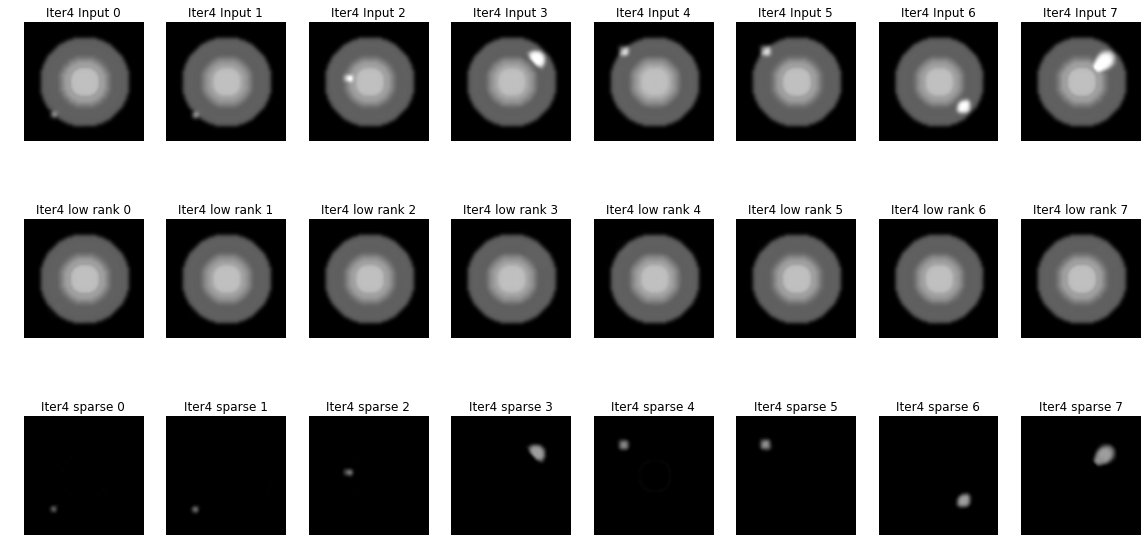

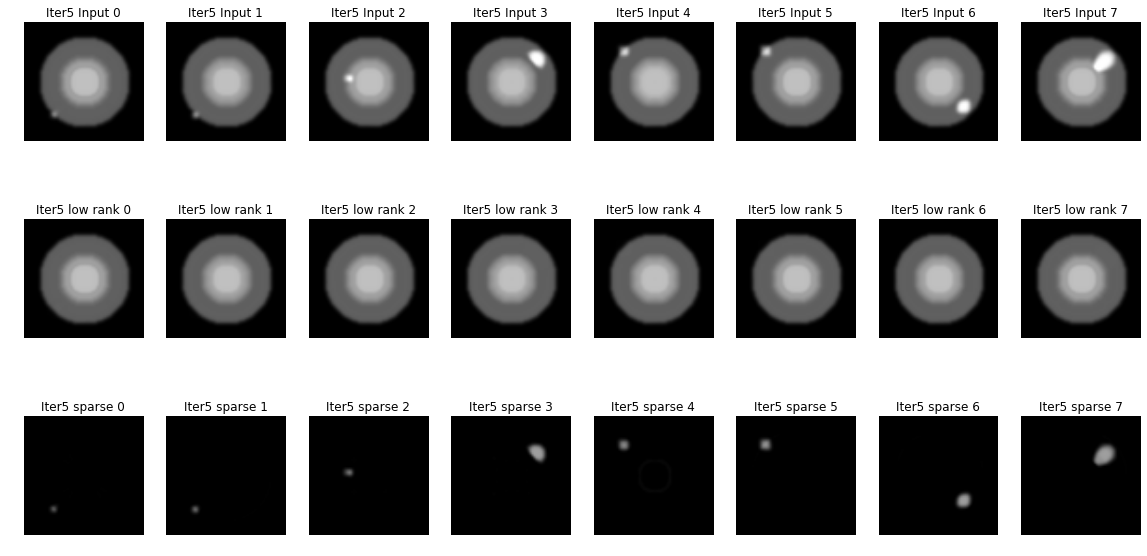

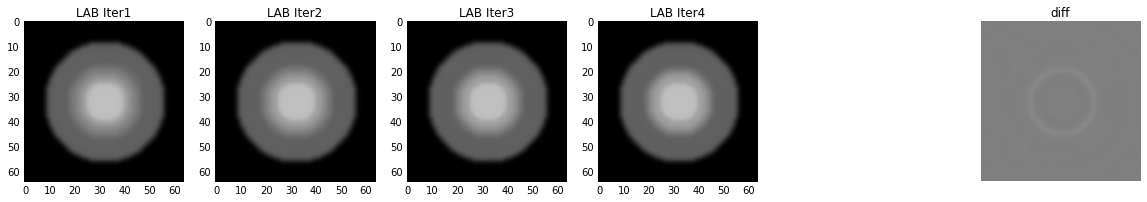

In [18]:
def  varyingCorruptionInputs(k):
    plt.figure(figsize=(20,10)) 
    for i in range(num_of_data):
        if  i > k:
             fn = data_folder+'/healthySimu'+str(i)+'.nrrd'
        else:
             fn = im_names[selection[i]]
        im_array = getImageArray(fn)
        plt.subplot(1,num_of_data,i+1)
        implot = plt.imshow(im_array,cm.gray,vmin = 0, vmax = 80) 
        plt.axis('off')  
        
        iter0Fn = result_folder+'/Iter0_'+str(i)+'.nrrd'
        im = sitk.GetImageFromArray(im_array)
        sitk.WriteImage(im,iter0Fn)
        
        iter0Fn = UAB_result_folder+'/Iter0_'+str(i)+'.nrrd'
        sitk.WriteImage(im,iter0Fn)
        

#increasing the corruption percentage 
d_uab = np.zeros(num_of_data+1)
d_lab = np.zeros(num_of_data+1)
for k in range(-1,num_of_data):
   varyingCorruptionInputs(k)
   d_uab[k+1] = runUAB(UAB_result_folder)
   d_lab[k+1] = runLAB(1.0)
    




UAB = [   4268.62229871   17978.3671758    18396.08115778  136216.85338069
  270962.19565989  345185.35669668  460740.17267991  622967.99976032
  725196.17209977]
LAB = [  4291.47362141  16567.08486167  19823.66925591  24427.99081361
  20344.32995177  12242.14491788  12290.06310306   4718.46370404
   4598.96205354]


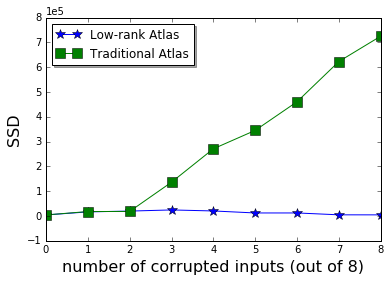

In [19]:
plt.figure()

plt.plot(range(num_of_data+1),d_lab,label='Low-rank Atlas',linestyle='-',marker='*', markersize=10)
plt.plot(range(num_of_data+1),d_uab,label='Traditional Atlas',linestyle='-',marker='s', markersize=10)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylim(-1e5,8e5)

print 'UAB =',d_uab
print 'LAB =',d_lab


plt.legend(loc='upper left', shadow=True)
plt.xlabel('number of corrupted inputs (out of 8)',fontsize=16)
plt.ylabel('SSD',fontsize=16)

plt.show()